In [2]:
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import sys, os
sys.path.insert(0, '/'.join(os.path.abspath(os.getcwd()).split('/')[:-1]))
from utils.imports import *
%matplotlib inline

batch_size = 64
learning_rate = 0.01
momentum = 0.5

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed);

In [3]:
train_loader = get_train_loader(batch_size)
test_loader = get_test_loader()

# Create the torch model and optimizer
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# torch.save(model.state_dict(), '../models/model.pth')
# torch.save(optimizer.state_dict(), '../models/optimizer.pth')


In [4]:
### INPUT:
num_epochs = 5

start = time.time()
train_losses = []
train_counter = []
test_losses = []
test_counter = []

# Load initialized parameters 
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed);
model.load_state_dict(torch.load('../models/initial_model.pth'))
optimizer.load_state_dict(torch.load('../models/initial_optimizer.pth'))

for epoch in range(num_epochs):
    s0 = time.time()
    train(model, optimizer, train_loader, train_losses, train_counter, test_loader, test_losses, test_counter, batch_size, epoch)
    print(f'{print_runtime(s0, False)}')
    
test(model, test_loader, test_losses, test_counter, epoch+1)
print_runtime(start)

/Users/Safak.Ozkan/opt/miniconda3/envs/ic_env/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch: 0   Train_Loss: 2.313107
epoch: 0   Train_Loss: 2.317955
epoch: 0   Train_Loss: 2.315581
epoch: 0   Train_Loss: 2.317469
epoch: 0   Train_Loss: 2.313193
epoch: 0   Train_Loss: 2.312184
epoch: 0   Train_Loss: 2.310759
epoch: 0   Train_Loss: 2.309034
epoch: 0   Train_Loss: 2.307372
epoch: 0   Train_Loss: 2.305995
epoch: 0   Train_Loss: 2.305034
epoch: 0   Train_Loss: 2.301305
epoch: 0   Train_Loss: 2.301607
epoch: 0   Train_Loss: 2.300093
epoch: 0   Train_Loss: 2.298955
epoch: 0   Train_Loss: 2.300568
epoch: 0   Train_Loss: 2.298563
epoch: 0   Train_Loss: 2.299226
epoch: 0   Train_Loss: 2.298483
epoch: 0   Train_Loss: 2.298291
epoch: 0   Train_Loss: 2.297660
epoch: 0   Train_Loss: 2.298581
epoch: 0   Train_Loss: 2.299045
epoch: 0   Train_Loss: 2.299067
epoch: 0   Train_Loss: 2.299599
epoch: 0   Train_Loss: 2.299072
epoch: 0   Train_Loss: 2.297793
epoch: 0   Train_Loss: 2.297188
epoch: 0   Train_Loss: 2.296203
epoch: 0   Train_Loss: 2.296237
epoch: 0   Train_Loss: 2.295258
epoch: 0

epoch: 0   Train_Loss: 1.764575
epoch: 0   Train_Loss: 1.761836
epoch: 0   Train_Loss: 1.758636
epoch: 0   Train_Loss: 1.755554
epoch: 0   Train_Loss: 1.752148
epoch: 0   Train_Loss: 1.749336
epoch: 0   Train_Loss: 1.746264
epoch: 0   Train_Loss: 1.742562
epoch: 0   Train_Loss: 1.739662
epoch: 0   Train_Loss: 1.735803
epoch: 0   Train_Loss: 1.733410
epoch: 0   Train_Loss: 1.731829
epoch: 0   Train_Loss: 1.728778
epoch: 0   Train_Loss: 1.726588
epoch: 0   Train_Loss: 1.723950
epoch: 0   Train_Loss: 1.721601
epoch: 0   Train_Loss: 1.719169
epoch: 0   Train_Loss: 1.715958
epoch: 0   Train_Loss: 1.713348
epoch: 0   Train_Loss: 1.710086
epoch: 0   Train_Loss: 1.707395
epoch: 0   Train_Loss: 1.703677
epoch: 0   Train_Loss: 1.700793
epoch: 0   Train_Loss: 1.697320


KeyboardInterrupt: 

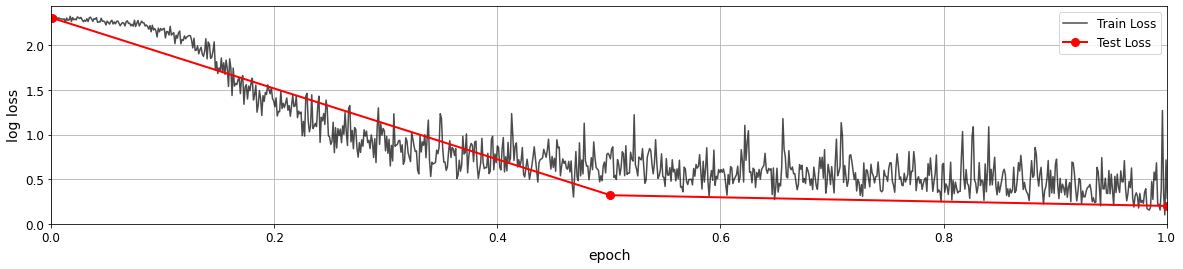

In [7]:
fig = plt.figure(figsize=(20, 4))
plt.plot(train_counter, train_losses, 'k-', alpha=.7)
plt.plot(test_counter, test_losses, 'r.-', linewidth=2, markersize=16)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('epoch', fontsize=14); plt.ylabel('log loss', fontsize=14); plt.xlim(0, train_counter[-1]); plt.ylim(0);

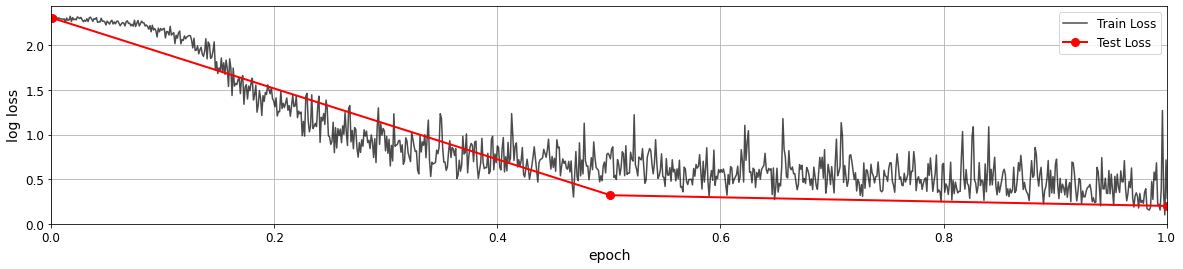

In [5]:
# Don't run this cell. 

---
## Experiments 

In [200]:
train_loader = get_train_loader(60000)
for (X_train_original, y_train_original) in train_loader:
    pass
for (X_test_original, y_test_original) in test_loader:
    pass

# Remove each of the train samples with labeled '1' on e at a time, and train the pytorch model
idx_remove = np.argwhere(y_train_original == 1)[0]


In [234]:
### INPUT:
num_epochs = 8
start = time.time()
grad = dict()

for q, ir in enumerate(idx_remove):
    mask = np.ones(len(X_train_original), dtype=bool)
    mask[ir] = False
    X_train = X_train_original[mask]
    y_train = y_train_original[mask]
    train_losses, train_counter, test_losses, test_counter = [], [], [], []

    random_seed = 42
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed);
    model.load_state_dict(torch.load('../models/initial_model.pth'))
    optimizer.load_state_dict(torch.load('../models/initial_optimizer.pth'))

    for epoch in range(num_epochs):
        train_with_torch_tensors(model, optimizer, train_losses, train_counter, test_loader, test_losses, test_counter,
                                 X_train, y_train, batch_size, epoch)
        
    print(f"\n{q+1}/{len(idx_remove)} finished {print_runtime(start, False)}\n")
    
    model.eval()
    output = model(X_test_original[idx_xt:idx_xt+1]).detach().numpy()[0]
    model.train()
    grad[ir.detach().tolist()] = output0 - output
    
    if (q+1) % 25 == 0:
        with open('../models/grad_dict.pkl', 'wb') as f:
            pickle.dump(grad, f)


epoch: 0   Train_Loss: 0.937353   Test_Loss: 0.195508   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.383413   Test_Loss: 0.130616   Accuracy: 96.17%
epoch: 2   Train_Loss: 0.302704   Test_Loss: 0.102754   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.260914   Test_Loss: 0.089757   Accuracy: 97.16%
epoch: 4   Train_Loss: 0.242291   Test_Loss: 0.082428   Accuracy: 97.52%
epoch: 5   Train_Loss: 0.220534   Test_Loss: 0.075860   Accuracy: 97.72%
epoch: 6   Train_Loss: 0.214815   Test_Loss: 0.066668   Accuracy: 97.96%
epoch: 7   Train_Loss: 0.203294   Test_Loss: 0.063032   Accuracy: 98.08%

1/6742 finished  (...Runtime: 0 min 42 sec)

epoch: 0   Train_Loss: 0.939496   Test_Loss: 0.196022   Accuracy: 94.15%
epoch: 1   Train_Loss: 0.383817   Test_Loss: 0.129294   Accuracy: 96.17%
epoch: 2   Train_Loss: 0.303386   Test_Loss: 0.103143   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.261154   Test_Loss: 0.090555   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.243404   Test_Loss: 0.083025   Accuracy: 97.47%
epoch

epoch: 0   Train_Loss: 0.940197   Test_Loss: 0.195609   Accuracy: 94.11%
epoch: 1   Train_Loss: 0.385917   Test_Loss: 0.130732   Accuracy: 96.09%
epoch: 2   Train_Loss: 0.304053   Test_Loss: 0.103295   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.262204   Test_Loss: 0.087989   Accuracy: 97.32%
epoch: 4   Train_Loss: 0.243453   Test_Loss: 0.080494   Accuracy: 97.57%
epoch: 5   Train_Loss: 0.221094   Test_Loss: 0.075145   Accuracy: 97.74%
epoch: 6   Train_Loss: 0.215210   Test_Loss: 0.066554   Accuracy: 97.93%
epoch: 7   Train_Loss: 0.203494   Test_Loss: 0.062334   Accuracy: 98.01%

14/6742 finished  (...Runtime: 9 min 48 sec)

epoch: 0   Train_Loss: 0.941881   Test_Loss: 0.198195   Accuracy: 94.09%
epoch: 1   Train_Loss: 0.385733   Test_Loss: 0.129334   Accuracy: 96.19%
epoch: 2   Train_Loss: 0.303686   Test_Loss: 0.103500   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.262021   Test_Loss: 0.088375   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.244398   Test_Loss: 0.080544   Accuracy: 97.62%
epoc

epoch: 0   Train_Loss: 0.943747   Test_Loss: 0.198810   Accuracy: 94.04%
epoch: 1   Train_Loss: 0.387442   Test_Loss: 0.130130   Accuracy: 96.13%
epoch: 2   Train_Loss: 0.306328   Test_Loss: 0.103600   Accuracy: 96.78%
epoch: 3   Train_Loss: 0.263171   Test_Loss: 0.088218   Accuracy: 97.29%
epoch: 4   Train_Loss: 0.245043   Test_Loss: 0.081565   Accuracy: 97.57%
epoch: 5   Train_Loss: 0.221550   Test_Loss: 0.075994   Accuracy: 97.76%
epoch: 6   Train_Loss: 0.215364   Test_Loss: 0.066135   Accuracy: 97.88%
epoch: 7   Train_Loss: 0.204039   Test_Loss: 0.063737   Accuracy: 98.00%

27/6742 finished  (...Runtime: 18 min 58 sec)

epoch: 0   Train_Loss: 0.943050   Test_Loss: 0.196900   Accuracy: 94.11%
epoch: 1   Train_Loss: 0.386483   Test_Loss: 0.129099   Accuracy: 96.14%
epoch: 2   Train_Loss: 0.304521   Test_Loss: 0.104087   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.262636   Test_Loss: 0.088018   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.244367   Test_Loss: 0.080212   Accuracy: 97.64%
epo

epoch: 0   Train_Loss: 0.941631   Test_Loss: 0.197705   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.385897   Test_Loss: 0.131818   Accuracy: 96.16%
epoch: 2   Train_Loss: 0.305038   Test_Loss: 0.103780   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.263505   Test_Loss: 0.088627   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.245583   Test_Loss: 0.081691   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.221894   Test_Loss: 0.076264   Accuracy: 97.64%
epoch: 6   Train_Loss: 0.216012   Test_Loss: 0.066153   Accuracy: 97.89%
epoch: 7   Train_Loss: 0.203889   Test_Loss: 0.061810   Accuracy: 98.04%

40/6742 finished  (...Runtime: 28 min  4 sec)

epoch: 0   Train_Loss: 0.942356   Test_Loss: 0.195622   Accuracy: 94.19%
epoch: 1   Train_Loss: 0.386073   Test_Loss: 0.131555   Accuracy: 96.10%
epoch: 2   Train_Loss: 0.304957   Test_Loss: 0.104938   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.263191   Test_Loss: 0.088012   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.245447   Test_Loss: 0.079923   Accuracy: 97.62%
epo

epoch: 0   Train_Loss: 0.941291   Test_Loss: 0.194325   Accuracy: 94.09%
epoch: 1   Train_Loss: 0.386297   Test_Loss: 0.130310   Accuracy: 96.13%
epoch: 2   Train_Loss: 0.304552   Test_Loss: 0.102186   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.262951   Test_Loss: 0.089787   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.244910   Test_Loss: 0.081655   Accuracy: 97.60%
epoch: 5   Train_Loss: 0.220851   Test_Loss: 0.075180   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.215909   Test_Loss: 0.066861   Accuracy: 97.85%
epoch: 7   Train_Loss: 0.203441   Test_Loss: 0.062693   Accuracy: 97.99%

53/6742 finished  (...Runtime: 37 min  2 sec)

epoch: 0   Train_Loss: 0.940540   Test_Loss: 0.195131   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.385532   Test_Loss: 0.130796   Accuracy: 96.15%
epoch: 2   Train_Loss: 0.304072   Test_Loss: 0.102714   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.262752   Test_Loss: 0.089767   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.245376   Test_Loss: 0.080637   Accuracy: 97.59%
epo

epoch: 0   Train_Loss: 0.938754   Test_Loss: 0.193395   Accuracy: 94.09%
epoch: 1   Train_Loss: 0.384289   Test_Loss: 0.130361   Accuracy: 96.04%
epoch: 2   Train_Loss: 0.304117   Test_Loss: 0.102279   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.262922   Test_Loss: 0.089916   Accuracy: 97.18%
epoch: 4   Train_Loss: 0.245513   Test_Loss: 0.080939   Accuracy: 97.62%
epoch: 5   Train_Loss: 0.222542   Test_Loss: 0.076571   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.216109   Test_Loss: 0.066135   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.203608   Test_Loss: 0.062664   Accuracy: 97.99%

66/6742 finished  (...Runtime: 46 min  1 sec)

epoch: 0   Train_Loss: 0.941643   Test_Loss: 0.195266   Accuracy: 93.98%
epoch: 1   Train_Loss: 0.385812   Test_Loss: 0.131036   Accuracy: 96.13%
epoch: 2   Train_Loss: 0.305109   Test_Loss: 0.103609   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.263123   Test_Loss: 0.088280   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.245672   Test_Loss: 0.081251   Accuracy: 97.62%
epo

epoch: 0   Train_Loss: 0.941541   Test_Loss: 0.196022   Accuracy: 94.11%
epoch: 1   Train_Loss: 0.387317   Test_Loss: 0.131128   Accuracy: 96.11%
epoch: 2   Train_Loss: 0.305200   Test_Loss: 0.102592   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.262545   Test_Loss: 0.088720   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.244878   Test_Loss: 0.081191   Accuracy: 97.60%
epoch: 5   Train_Loss: 0.221528   Test_Loss: 0.076039   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.215293   Test_Loss: 0.066385   Accuracy: 97.93%
epoch: 7   Train_Loss: 0.203052   Test_Loss: 0.063657   Accuracy: 98.05%

79/6742 finished  (...Runtime: 55 min  6 sec)

epoch: 0   Train_Loss: 0.939778   Test_Loss: 0.196254   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.386711   Test_Loss: 0.130977   Accuracy: 96.06%
epoch: 2   Train_Loss: 0.305022   Test_Loss: 0.104230   Accuracy: 96.75%
epoch: 3   Train_Loss: 0.262429   Test_Loss: 0.088973   Accuracy: 97.29%
epoch: 4   Train_Loss: 0.245483   Test_Loss: 0.080323   Accuracy: 97.64%
epo

epoch: 0   Train_Loss: 0.940718   Test_Loss: 0.196821   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.387431   Test_Loss: 0.130823   Accuracy: 96.00%
epoch: 2   Train_Loss: 0.305884   Test_Loss: 0.103323   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.262977   Test_Loss: 0.087817   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.246051   Test_Loss: 0.078925   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.222510   Test_Loss: 0.075281   Accuracy: 97.74%
epoch: 6   Train_Loss: 0.215810   Test_Loss: 0.066202   Accuracy: 97.92%
epoch: 7   Train_Loss: 0.203832   Test_Loss: 0.063163   Accuracy: 98.06%

92/6742 finished  (...Runtime: 64 min  7 sec)

epoch: 0   Train_Loss: 0.940054   Test_Loss: 0.195228   Accuracy: 94.08%
epoch: 1   Train_Loss: 0.384677   Test_Loss: 0.131950   Accuracy: 96.12%
epoch: 2   Train_Loss: 0.304114   Test_Loss: 0.102460   Accuracy: 96.94%
epoch: 3   Train_Loss: 0.262247   Test_Loss: 0.088343   Accuracy: 97.33%
epoch: 4   Train_Loss: 0.245708   Test_Loss: 0.080510   Accuracy: 97.60%
epo

epoch: 0   Train_Loss: 0.940105   Test_Loss: 0.196851   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.387040   Test_Loss: 0.131007   Accuracy: 96.10%
epoch: 2   Train_Loss: 0.306357   Test_Loss: 0.103001   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.263954   Test_Loss: 0.089137   Accuracy: 97.21%
epoch: 4   Train_Loss: 0.245737   Test_Loss: 0.080152   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.221954   Test_Loss: 0.076640   Accuracy: 97.62%
epoch: 6   Train_Loss: 0.215395   Test_Loss: 0.067452   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.203302   Test_Loss: 0.063755   Accuracy: 98.00%

105/6742 finished  (...Runtime: 73 min  8 sec)

epoch: 0   Train_Loss: 0.939210   Test_Loss: 0.195319   Accuracy: 94.07%
epoch: 1   Train_Loss: 0.386613   Test_Loss: 0.130733   Accuracy: 96.03%
epoch: 2   Train_Loss: 0.305682   Test_Loss: 0.103546   Accuracy: 96.77%
epoch: 3   Train_Loss: 0.263774   Test_Loss: 0.088630   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.246525   Test_Loss: 0.080673   Accuracy: 97.55%
ep

epoch: 0   Train_Loss: 0.941694   Test_Loss: 0.197948   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.388358   Test_Loss: 0.130037   Accuracy: 96.15%
epoch: 2   Train_Loss: 0.306808   Test_Loss: 0.101849   Accuracy: 96.94%
epoch: 3   Train_Loss: 0.264100   Test_Loss: 0.088809   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.246441   Test_Loss: 0.080111   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.222740   Test_Loss: 0.077652   Accuracy: 97.65%
epoch: 6   Train_Loss: 0.218029   Test_Loss: 0.067430   Accuracy: 97.88%
epoch: 7   Train_Loss: 0.205280   Test_Loss: 0.063970   Accuracy: 98.00%

118/6742 finished  (...Runtime: 82 min  7 sec)

epoch: 0   Train_Loss: 0.941524   Test_Loss: 0.198270   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.389231   Test_Loss: 0.131374   Accuracy: 96.12%
epoch: 2   Train_Loss: 0.307141   Test_Loss: 0.102630   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.263671   Test_Loss: 0.088235   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.245083   Test_Loss: 0.079671   Accuracy: 97.57%
ep

epoch: 0   Train_Loss: 0.939636   Test_Loss: 0.195398   Accuracy: 93.99%
epoch: 1   Train_Loss: 0.384903   Test_Loss: 0.130239   Accuracy: 96.09%
epoch: 2   Train_Loss: 0.304346   Test_Loss: 0.102814   Accuracy: 96.96%
epoch: 3   Train_Loss: 0.262868   Test_Loss: 0.088271   Accuracy: 97.20%
epoch: 4   Train_Loss: 0.245609   Test_Loss: 0.080197   Accuracy: 97.51%
epoch: 5   Train_Loss: 0.222943   Test_Loss: 0.075122   Accuracy: 97.80%
epoch: 6   Train_Loss: 0.216056   Test_Loss: 0.065750   Accuracy: 97.93%
epoch: 7   Train_Loss: 0.203399   Test_Loss: 0.063399   Accuracy: 98.02%

131/6742 finished  (...Runtime: 91 min  6 sec)

epoch: 0   Train_Loss: 0.940003   Test_Loss: 0.195137   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.385773   Test_Loss: 0.130187   Accuracy: 96.05%
epoch: 2   Train_Loss: 0.305579   Test_Loss: 0.104283   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.263897   Test_Loss: 0.087997   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.245559   Test_Loss: 0.079866   Accuracy: 97.51%
ep

epoch: 0   Train_Loss: 0.941560   Test_Loss: 0.197666   Accuracy: 93.92%
epoch: 1   Train_Loss: 0.387964   Test_Loss: 0.129818   Accuracy: 96.13%
epoch: 2   Train_Loss: 0.306602   Test_Loss: 0.101342   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.264997   Test_Loss: 0.087995   Accuracy: 97.32%
epoch: 4   Train_Loss: 0.245971   Test_Loss: 0.079831   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.222799   Test_Loss: 0.076252   Accuracy: 97.78%
epoch: 6   Train_Loss: 0.216646   Test_Loss: 0.066724   Accuracy: 97.99%
epoch: 7   Train_Loss: 0.205022   Test_Loss: 0.064981   Accuracy: 97.98%

144/6742 finished  (...Runtime: 100 min  9 sec)

epoch: 0   Train_Loss: 0.941311   Test_Loss: 0.196122   Accuracy: 94.04%
epoch: 1   Train_Loss: 0.387452   Test_Loss: 0.130564   Accuracy: 96.13%
epoch: 2   Train_Loss: 0.305450   Test_Loss: 0.102103   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.262729   Test_Loss: 0.087298   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.246575   Test_Loss: 0.079969   Accuracy: 97.51%
e

epoch: 0   Train_Loss: 0.941194   Test_Loss: 0.197007   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.386035   Test_Loss: 0.130332   Accuracy: 96.10%
epoch: 2   Train_Loss: 0.304823   Test_Loss: 0.100162   Accuracy: 96.96%
epoch: 3   Train_Loss: 0.263928   Test_Loss: 0.087860   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.246383   Test_Loss: 0.079898   Accuracy: 97.60%
epoch: 5   Train_Loss: 0.221871   Test_Loss: 0.075451   Accuracy: 97.79%
epoch: 6   Train_Loss: 0.215049   Test_Loss: 0.065681   Accuracy: 98.00%
epoch: 7   Train_Loss: 0.203610   Test_Loss: 0.064015   Accuracy: 98.03%

157/6742 finished  (...Runtime: 109 min  7 sec)

epoch: 0   Train_Loss: 0.941081   Test_Loss: 0.197622   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.387107   Test_Loss: 0.130265   Accuracy: 96.05%
epoch: 2   Train_Loss: 0.305352   Test_Loss: 0.101680   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.264028   Test_Loss: 0.089334   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.246924   Test_Loss: 0.079149   Accuracy: 97.56%
e

epoch: 0   Train_Loss: 0.942715   Test_Loss: 0.197087   Accuracy: 93.91%
epoch: 1   Train_Loss: 0.386191   Test_Loss: 0.130828   Accuracy: 96.06%
epoch: 2   Train_Loss: 0.305426   Test_Loss: 0.102061   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.263655   Test_Loss: 0.088803   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.246091   Test_Loss: 0.080707   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.222957   Test_Loss: 0.076375   Accuracy: 97.74%
epoch: 6   Train_Loss: 0.215306   Test_Loss: 0.067021   Accuracy: 97.96%
epoch: 7   Train_Loss: 0.204977   Test_Loss: 0.064099   Accuracy: 98.01%

170/6742 finished  (...Runtime: 118 min 18 sec)

epoch: 0   Train_Loss: 0.942902   Test_Loss: 0.199017   Accuracy: 93.92%
epoch: 1   Train_Loss: 0.386976   Test_Loss: 0.132058   Accuracy: 96.00%
epoch: 2   Train_Loss: 0.305963   Test_Loss: 0.101303   Accuracy: 96.80%
epoch: 3   Train_Loss: 0.265227   Test_Loss: 0.088156   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.247009   Test_Loss: 0.079321   Accuracy: 97.59%
e

epoch: 0   Train_Loss: 0.942981   Test_Loss: 0.198878   Accuracy: 93.85%
epoch: 1   Train_Loss: 0.388353   Test_Loss: 0.130718   Accuracy: 96.04%
epoch: 2   Train_Loss: 0.306225   Test_Loss: 0.102593   Accuracy: 96.85%
epoch: 3   Train_Loss: 0.264808   Test_Loss: 0.087423   Accuracy: 97.32%
epoch: 4   Train_Loss: 0.246050   Test_Loss: 0.080069   Accuracy: 97.51%
epoch: 5   Train_Loss: 0.223483   Test_Loss: 0.077817   Accuracy: 97.72%
epoch: 6   Train_Loss: 0.215692   Test_Loss: 0.067489   Accuracy: 97.90%
epoch: 7   Train_Loss: 0.206716   Test_Loss: 0.064863   Accuracy: 97.99%

183/6742 finished  (...Runtime: 127 min 14 sec)

epoch: 0   Train_Loss: 0.943808   Test_Loss: 0.198945   Accuracy: 93.89%
epoch: 1   Train_Loss: 0.387783   Test_Loss: 0.133117   Accuracy: 95.90%
epoch: 2   Train_Loss: 0.305714   Test_Loss: 0.102688   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.263956   Test_Loss: 0.088667   Accuracy: 97.21%
epoch: 4   Train_Loss: 0.246529   Test_Loss: 0.079938   Accuracy: 97.50%
e

epoch: 0   Train_Loss: 0.942735   Test_Loss: 0.198815   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.386562   Test_Loss: 0.131739   Accuracy: 95.96%
epoch: 2   Train_Loss: 0.305472   Test_Loss: 0.102773   Accuracy: 96.77%
epoch: 3   Train_Loss: 0.263771   Test_Loss: 0.087997   Accuracy: 97.18%
epoch: 4   Train_Loss: 0.246698   Test_Loss: 0.080131   Accuracy: 97.45%
epoch: 5   Train_Loss: 0.223612   Test_Loss: 0.076113   Accuracy: 97.72%
epoch: 6   Train_Loss: 0.216057   Test_Loss: 0.067130   Accuracy: 97.88%
epoch: 7   Train_Loss: 0.205307   Test_Loss: 0.063634   Accuracy: 97.95%

196/6742 finished  (...Runtime: 136 min 12 sec)

epoch: 0   Train_Loss: 0.942988   Test_Loss: 0.198327   Accuracy: 93.95%
epoch: 1   Train_Loss: 0.387107   Test_Loss: 0.131440   Accuracy: 95.90%
epoch: 2   Train_Loss: 0.306077   Test_Loss: 0.102866   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.263881   Test_Loss: 0.087856   Accuracy: 97.32%
epoch: 4   Train_Loss: 0.246167   Test_Loss: 0.079244   Accuracy: 97.50%
e

epoch: 0   Train_Loss: 0.943238   Test_Loss: 0.198860   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.387148   Test_Loss: 0.132092   Accuracy: 95.95%
epoch: 2   Train_Loss: 0.305733   Test_Loss: 0.101351   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.263825   Test_Loss: 0.088701   Accuracy: 97.33%
epoch: 4   Train_Loss: 0.245786   Test_Loss: 0.079799   Accuracy: 97.54%
epoch: 5   Train_Loss: 0.222050   Test_Loss: 0.076086   Accuracy: 97.74%
epoch: 6   Train_Loss: 0.215089   Test_Loss: 0.066744   Accuracy: 97.93%
epoch: 7   Train_Loss: 0.205278   Test_Loss: 0.062222   Accuracy: 98.03%

209/6742 finished  (...Runtime: 145 min 10 sec)

epoch: 0   Train_Loss: 0.944840   Test_Loss: 0.198116   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.387693   Test_Loss: 0.131657   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.305591   Test_Loss: 0.102106   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.264165   Test_Loss: 0.087736   Accuracy: 97.39%
epoch: 4   Train_Loss: 0.245699   Test_Loss: 0.079194   Accuracy: 97.64%
e

epoch: 0   Train_Loss: 0.945734   Test_Loss: 0.200152   Accuracy: 93.97%
epoch: 1   Train_Loss: 0.387527   Test_Loss: 0.131700   Accuracy: 95.98%
epoch: 2   Train_Loss: 0.304453   Test_Loss: 0.102647   Accuracy: 96.78%
epoch: 3   Train_Loss: 0.262252   Test_Loss: 0.087442   Accuracy: 97.32%
epoch: 4   Train_Loss: 0.245768   Test_Loss: 0.080027   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.222518   Test_Loss: 0.075514   Accuracy: 97.70%
epoch: 6   Train_Loss: 0.215522   Test_Loss: 0.066430   Accuracy: 97.90%
epoch: 7   Train_Loss: 0.204828   Test_Loss: 0.062902   Accuracy: 98.06%

222/6742 finished  (...Runtime: 154 min  9 sec)

epoch: 0   Train_Loss: 0.946757   Test_Loss: 0.200045   Accuracy: 93.92%
epoch: 1   Train_Loss: 0.389079   Test_Loss: 0.133326   Accuracy: 96.01%
epoch: 2   Train_Loss: 0.306111   Test_Loss: 0.101972   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.264175   Test_Loss: 0.088297   Accuracy: 97.35%
epoch: 4   Train_Loss: 0.246157   Test_Loss: 0.080840   Accuracy: 97.54%
e

epoch: 0   Train_Loss: 0.945628   Test_Loss: 0.198305   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.387658   Test_Loss: 0.131910   Accuracy: 96.03%
epoch: 2   Train_Loss: 0.304978   Test_Loss: 0.100862   Accuracy: 96.93%
epoch: 3   Train_Loss: 0.262232   Test_Loss: 0.088188   Accuracy: 97.33%
epoch: 4   Train_Loss: 0.244540   Test_Loss: 0.078239   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.221605   Test_Loss: 0.076036   Accuracy: 97.67%
epoch: 6   Train_Loss: 0.214536   Test_Loss: 0.066127   Accuracy: 97.91%
epoch: 7   Train_Loss: 0.204099   Test_Loss: 0.062525   Accuracy: 98.11%

235/6742 finished  (...Runtime: 163 min  8 sec)

epoch: 0   Train_Loss: 0.945570   Test_Loss: 0.199014   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.388944   Test_Loss: 0.133382   Accuracy: 95.92%
epoch: 2   Train_Loss: 0.306047   Test_Loss: 0.101819   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.264030   Test_Loss: 0.088840   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.245214   Test_Loss: 0.079364   Accuracy: 97.51%
e

epoch: 0   Train_Loss: 0.945208   Test_Loss: 0.197722   Accuracy: 94.04%
epoch: 1   Train_Loss: 0.388354   Test_Loss: 0.133781   Accuracy: 95.92%
epoch: 2   Train_Loss: 0.307157   Test_Loss: 0.101012   Accuracy: 96.93%
epoch: 3   Train_Loss: 0.262877   Test_Loss: 0.089923   Accuracy: 97.14%
epoch: 4   Train_Loss: 0.245700   Test_Loss: 0.078446   Accuracy: 97.63%
epoch: 5   Train_Loss: 0.221485   Test_Loss: 0.074958   Accuracy: 97.76%
epoch: 6   Train_Loss: 0.215304   Test_Loss: 0.066830   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.205165   Test_Loss: 0.062707   Accuracy: 98.10%

248/6742 finished  (...Runtime: 172 min  9 sec)

epoch: 0   Train_Loss: 0.945021   Test_Loss: 0.199522   Accuracy: 93.93%
epoch: 1   Train_Loss: 0.388449   Test_Loss: 0.132361   Accuracy: 96.04%
epoch: 2   Train_Loss: 0.305724   Test_Loss: 0.102414   Accuracy: 96.98%
epoch: 3   Train_Loss: 0.263551   Test_Loss: 0.089163   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.244801   Test_Loss: 0.079191   Accuracy: 97.52%
e

epoch: 0   Train_Loss: 0.943770   Test_Loss: 0.198832   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.388020   Test_Loss: 0.131550   Accuracy: 96.01%
epoch: 2   Train_Loss: 0.306630   Test_Loss: 0.101647   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.263608   Test_Loss: 0.089483   Accuracy: 97.18%
epoch: 4   Train_Loss: 0.246375   Test_Loss: 0.080058   Accuracy: 97.58%
epoch: 5   Train_Loss: 0.222331   Test_Loss: 0.075115   Accuracy: 97.75%
epoch: 6   Train_Loss: 0.215603   Test_Loss: 0.067704   Accuracy: 97.83%
epoch: 7   Train_Loss: 0.205882   Test_Loss: 0.062789   Accuracy: 98.00%

261/6742 finished  (...Runtime: 181 min  6 sec)

epoch: 0   Train_Loss: 0.944692   Test_Loss: 0.199262   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.389431   Test_Loss: 0.134094   Accuracy: 95.95%
epoch: 2   Train_Loss: 0.306952   Test_Loss: 0.102721   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.263385   Test_Loss: 0.089359   Accuracy: 97.19%
epoch: 4   Train_Loss: 0.245581   Test_Loss: 0.079484   Accuracy: 97.61%
e

epoch: 0   Train_Loss: 0.946216   Test_Loss: 0.198211   Accuracy: 93.93%
epoch: 1   Train_Loss: 0.389518   Test_Loss: 0.133455   Accuracy: 96.06%
epoch: 2   Train_Loss: 0.308139   Test_Loss: 0.102392   Accuracy: 96.95%
epoch: 3   Train_Loss: 0.264109   Test_Loss: 0.088827   Accuracy: 97.20%
epoch: 4   Train_Loss: 0.246990   Test_Loss: 0.079987   Accuracy: 97.62%
epoch: 5   Train_Loss: 0.223252   Test_Loss: 0.075870   Accuracy: 97.70%
epoch: 6   Train_Loss: 0.217252   Test_Loss: 0.066844   Accuracy: 97.98%
epoch: 7   Train_Loss: 0.206090   Test_Loss: 0.062745   Accuracy: 98.08%

274/6742 finished  (...Runtime: 190 min  3 sec)

epoch: 0   Train_Loss: 0.945360   Test_Loss: 0.199116   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.388970   Test_Loss: 0.133012   Accuracy: 96.03%
epoch: 2   Train_Loss: 0.308162   Test_Loss: 0.103300   Accuracy: 96.80%
epoch: 3   Train_Loss: 0.263501   Test_Loss: 0.088002   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.246382   Test_Loss: 0.080101   Accuracy: 97.66%
e

epoch: 0   Train_Loss: 0.945390   Test_Loss: 0.197545   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.387159   Test_Loss: 0.133300   Accuracy: 95.97%
epoch: 2   Train_Loss: 0.307451   Test_Loss: 0.102852   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.262971   Test_Loss: 0.089380   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.246426   Test_Loss: 0.079494   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.221940   Test_Loss: 0.075677   Accuracy: 97.71%
epoch: 6   Train_Loss: 0.214643   Test_Loss: 0.066756   Accuracy: 97.92%
epoch: 7   Train_Loss: 0.204664   Test_Loss: 0.062565   Accuracy: 98.05%

287/6742 finished  (...Runtime: 199 min  0 sec)

epoch: 0   Train_Loss: 0.945086   Test_Loss: 0.197152   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.388320   Test_Loss: 0.133569   Accuracy: 95.99%
epoch: 2   Train_Loss: 0.307998   Test_Loss: 0.103616   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.264334   Test_Loss: 0.088731   Accuracy: 97.21%
epoch: 4   Train_Loss: 0.246724   Test_Loss: 0.079029   Accuracy: 97.53%
e

epoch: 0   Train_Loss: 0.944988   Test_Loss: 0.198049   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.386682   Test_Loss: 0.131930   Accuracy: 96.02%
epoch: 2   Train_Loss: 0.306733   Test_Loss: 0.102238   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.262885   Test_Loss: 0.089695   Accuracy: 97.18%
epoch: 4   Train_Loss: 0.245597   Test_Loss: 0.078138   Accuracy: 97.64%
epoch: 5   Train_Loss: 0.222542   Test_Loss: 0.075684   Accuracy: 97.73%
epoch: 6   Train_Loss: 0.214266   Test_Loss: 0.066686   Accuracy: 97.97%
epoch: 7   Train_Loss: 0.204365   Test_Loss: 0.062536   Accuracy: 98.11%

300/6742 finished  (...Runtime: 207 min 58 sec)

epoch: 0   Train_Loss: 0.945061   Test_Loss: 0.197964   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.387654   Test_Loss: 0.131463   Accuracy: 96.04%
epoch: 2   Train_Loss: 0.306937   Test_Loss: 0.102530   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.263568   Test_Loss: 0.090336   Accuracy: 97.19%
epoch: 4   Train_Loss: 0.246035   Test_Loss: 0.078627   Accuracy: 97.53%
e

epoch: 0   Train_Loss: 0.943811   Test_Loss: 0.198601   Accuracy: 93.92%
epoch: 1   Train_Loss: 0.385321   Test_Loss: 0.132072   Accuracy: 96.07%
epoch: 2   Train_Loss: 0.305790   Test_Loss: 0.101789   Accuracy: 96.97%
epoch: 3   Train_Loss: 0.263229   Test_Loss: 0.088935   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.245279   Test_Loss: 0.077073   Accuracy: 97.58%
epoch: 5   Train_Loss: 0.221570   Test_Loss: 0.075045   Accuracy: 97.75%
epoch: 6   Train_Loss: 0.214046   Test_Loss: 0.066816   Accuracy: 97.90%
epoch: 7   Train_Loss: 0.204505   Test_Loss: 0.063885   Accuracy: 98.01%

313/6742 finished  (...Runtime: 216 min 53 sec)

epoch: 0   Train_Loss: 0.943802   Test_Loss: 0.198634   Accuracy: 93.95%
epoch: 1   Train_Loss: 0.386783   Test_Loss: 0.134367   Accuracy: 95.90%
epoch: 2   Train_Loss: 0.307096   Test_Loss: 0.102037   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.263279   Test_Loss: 0.089575   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.245671   Test_Loss: 0.078160   Accuracy: 97.56%
e

epoch: 0   Train_Loss: 0.944892   Test_Loss: 0.196468   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.385987   Test_Loss: 0.130409   Accuracy: 96.07%
epoch: 2   Train_Loss: 0.306094   Test_Loss: 0.103678   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.264044   Test_Loss: 0.089046   Accuracy: 97.31%
epoch: 4   Train_Loss: 0.246305   Test_Loss: 0.080007   Accuracy: 97.52%
epoch: 5   Train_Loss: 0.223093   Test_Loss: 0.075623   Accuracy: 97.66%
epoch: 6   Train_Loss: 0.215425   Test_Loss: 0.066306   Accuracy: 97.93%
epoch: 7   Train_Loss: 0.205465   Test_Loss: 0.064078   Accuracy: 98.06%

326/6742 finished  (...Runtime: 225 min 51 sec)

epoch: 0   Train_Loss: 0.945180   Test_Loss: 0.198812   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.388768   Test_Loss: 0.132121   Accuracy: 96.08%
epoch: 2   Train_Loss: 0.307920   Test_Loss: 0.101850   Accuracy: 97.00%
epoch: 3   Train_Loss: 0.264597   Test_Loss: 0.087538   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.246452   Test_Loss: 0.078070   Accuracy: 97.54%
e

epoch: 0   Train_Loss: 0.945712   Test_Loss: 0.199688   Accuracy: 93.88%
epoch: 1   Train_Loss: 0.387749   Test_Loss: 0.133173   Accuracy: 96.01%
epoch: 2   Train_Loss: 0.306944   Test_Loss: 0.102309   Accuracy: 96.95%
epoch: 3   Train_Loss: 0.264119   Test_Loss: 0.090093   Accuracy: 97.16%
epoch: 4   Train_Loss: 0.246469   Test_Loss: 0.078407   Accuracy: 97.60%
epoch: 5   Train_Loss: 0.222122   Test_Loss: 0.076577   Accuracy: 97.70%
epoch: 6   Train_Loss: 0.215586   Test_Loss: 0.066138   Accuracy: 97.97%
epoch: 7   Train_Loss: 0.203931   Test_Loss: 0.062341   Accuracy: 98.06%

339/6742 finished  (...Runtime: 234 min 55 sec)

epoch: 0   Train_Loss: 0.945910   Test_Loss: 0.197763   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.388633   Test_Loss: 0.132505   Accuracy: 96.04%
epoch: 2   Train_Loss: 0.308281   Test_Loss: 0.102802   Accuracy: 96.94%
epoch: 3   Train_Loss: 0.264495   Test_Loss: 0.089261   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.247714   Test_Loss: 0.078140   Accuracy: 97.64%
e

epoch: 0   Train_Loss: 0.945412   Test_Loss: 0.199064   Accuracy: 93.92%
epoch: 1   Train_Loss: 0.388649   Test_Loss: 0.134136   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.307990   Test_Loss: 0.102525   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.263751   Test_Loss: 0.089584   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.247099   Test_Loss: 0.078503   Accuracy: 97.58%
epoch: 5   Train_Loss: 0.222349   Test_Loss: 0.076632   Accuracy: 97.69%
epoch: 6   Train_Loss: 0.214394   Test_Loss: 0.066015   Accuracy: 97.94%
epoch: 7   Train_Loss: 0.203736   Test_Loss: 0.063239   Accuracy: 98.10%

352/6742 finished  (...Runtime: 243 min 52 sec)

epoch: 0   Train_Loss: 0.945082   Test_Loss: 0.197111   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.386555   Test_Loss: 0.132289   Accuracy: 95.98%
epoch: 2   Train_Loss: 0.306373   Test_Loss: 0.102140   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.263514   Test_Loss: 0.090266   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.245350   Test_Loss: 0.078831   Accuracy: 97.62%
e

epoch: 0   Train_Loss: 0.946555   Test_Loss: 0.197459   Accuracy: 93.96%
epoch: 1   Train_Loss: 0.386520   Test_Loss: 0.131166   Accuracy: 96.05%
epoch: 2   Train_Loss: 0.306561   Test_Loss: 0.101564   Accuracy: 96.96%
epoch: 3   Train_Loss: 0.264291   Test_Loss: 0.089284   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.246105   Test_Loss: 0.078823   Accuracy: 97.62%
epoch: 5   Train_Loss: 0.222169   Test_Loss: 0.076531   Accuracy: 97.64%
epoch: 6   Train_Loss: 0.214851   Test_Loss: 0.066447   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.204381   Test_Loss: 0.063620   Accuracy: 98.17%

365/6742 finished  (...Runtime: 252 min 50 sec)

epoch: 0   Train_Loss: 0.946034   Test_Loss: 0.198617   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.385982   Test_Loss: 0.132833   Accuracy: 95.97%
epoch: 2   Train_Loss: 0.306450   Test_Loss: 0.102679   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.263447   Test_Loss: 0.089942   Accuracy: 97.13%
epoch: 4   Train_Loss: 0.246148   Test_Loss: 0.079714   Accuracy: 97.58%
e

epoch: 0   Train_Loss: 0.946639   Test_Loss: 0.198028   Accuracy: 93.96%
epoch: 1   Train_Loss: 0.386905   Test_Loss: 0.132617   Accuracy: 95.92%
epoch: 2   Train_Loss: 0.306649   Test_Loss: 0.102357   Accuracy: 96.93%
epoch: 3   Train_Loss: 0.263674   Test_Loss: 0.088953   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.246544   Test_Loss: 0.079188   Accuracy: 97.52%
epoch: 5   Train_Loss: 0.222456   Test_Loss: 0.076137   Accuracy: 97.67%
epoch: 6   Train_Loss: 0.215078   Test_Loss: 0.068047   Accuracy: 97.81%
epoch: 7   Train_Loss: 0.205495   Test_Loss: 0.064084   Accuracy: 98.10%

378/6742 finished  (...Runtime: 261 min 46 sec)

epoch: 0   Train_Loss: 0.946033   Test_Loss: 0.197322   Accuracy: 93.95%
epoch: 1   Train_Loss: 0.386599   Test_Loss: 0.130421   Accuracy: 96.05%
epoch: 2   Train_Loss: 0.305536   Test_Loss: 0.102594   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.262767   Test_Loss: 0.090680   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.245408   Test_Loss: 0.078100   Accuracy: 97.61%
e

epoch: 0   Train_Loss: 0.947355   Test_Loss: 0.198458   Accuracy: 93.83%
epoch: 1   Train_Loss: 0.387150   Test_Loss: 0.129743   Accuracy: 96.07%
epoch: 2   Train_Loss: 0.306203   Test_Loss: 0.103195   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.263258   Test_Loss: 0.088174   Accuracy: 97.33%
epoch: 4   Train_Loss: 0.245372   Test_Loss: 0.078651   Accuracy: 97.55%
epoch: 5   Train_Loss: 0.221578   Test_Loss: 0.075925   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.214718   Test_Loss: 0.066031   Accuracy: 97.99%
epoch: 7   Train_Loss: 0.204564   Test_Loss: 0.063933   Accuracy: 98.12%

391/6742 finished  (...Runtime: 270 min 55 sec)

epoch: 0   Train_Loss: 0.947746   Test_Loss: 0.198903   Accuracy: 93.88%
epoch: 1   Train_Loss: 0.386003   Test_Loss: 0.131147   Accuracy: 96.01%
epoch: 2   Train_Loss: 0.305206   Test_Loss: 0.102147   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.262458   Test_Loss: 0.089461   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.245537   Test_Loss: 0.078165   Accuracy: 97.62%
e

epoch: 0   Train_Loss: 0.947517   Test_Loss: 0.196985   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.386408   Test_Loss: 0.132318   Accuracy: 95.98%
epoch: 2   Train_Loss: 0.305484   Test_Loss: 0.102377   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.262849   Test_Loss: 0.090149   Accuracy: 97.19%
epoch: 4   Train_Loss: 0.245657   Test_Loss: 0.078695   Accuracy: 97.64%
epoch: 5   Train_Loss: 0.221984   Test_Loss: 0.076291   Accuracy: 97.70%
epoch: 6   Train_Loss: 0.215093   Test_Loss: 0.066954   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.204442   Test_Loss: 0.064480   Accuracy: 98.07%

404/6742 finished  (...Runtime: 280 min 10 sec)

epoch: 0   Train_Loss: 0.947290   Test_Loss: 0.197746   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.385969   Test_Loss: 0.132395   Accuracy: 96.02%
epoch: 2   Train_Loss: 0.305593   Test_Loss: 0.103217   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.263294   Test_Loss: 0.088971   Accuracy: 97.31%
epoch: 4   Train_Loss: 0.245446   Test_Loss: 0.078711   Accuracy: 97.57%
e

epoch: 0   Train_Loss: 0.948313   Test_Loss: 0.197773   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.386158   Test_Loss: 0.133085   Accuracy: 96.03%
epoch: 2   Train_Loss: 0.304695   Test_Loss: 0.101593   Accuracy: 97.00%
epoch: 3   Train_Loss: 0.261946   Test_Loss: 0.089160   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.244006   Test_Loss: 0.078063   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.220363   Test_Loss: 0.075697   Accuracy: 97.66%
epoch: 6   Train_Loss: 0.213869   Test_Loss: 0.067404   Accuracy: 97.97%
epoch: 7   Train_Loss: 0.203283   Test_Loss: 0.064480   Accuracy: 98.10%

417/6742 finished  (...Runtime: 289 min 36 sec)

epoch: 0   Train_Loss: 0.947778   Test_Loss: 0.196857   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.385784   Test_Loss: 0.133211   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.305284   Test_Loss: 0.102949   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.262669   Test_Loss: 0.089430   Accuracy: 97.33%
epoch: 4   Train_Loss: 0.245811   Test_Loss: 0.078871   Accuracy: 97.59%
e

epoch: 0   Train_Loss: 0.948072   Test_Loss: 0.198698   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.385966   Test_Loss: 0.132306   Accuracy: 96.00%
epoch: 2   Train_Loss: 0.304958   Test_Loss: 0.101880   Accuracy: 96.95%
epoch: 3   Train_Loss: 0.261664   Test_Loss: 0.087980   Accuracy: 97.32%
epoch: 4   Train_Loss: 0.244489   Test_Loss: 0.078733   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.220719   Test_Loss: 0.076832   Accuracy: 97.64%
epoch: 6   Train_Loss: 0.214012   Test_Loss: 0.066935   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.204339   Test_Loss: 0.064725   Accuracy: 98.02%

430/6742 finished  (...Runtime: 299 min  4 sec)

epoch: 0   Train_Loss: 0.947842   Test_Loss: 0.198172   Accuracy: 93.98%
epoch: 1   Train_Loss: 0.385591   Test_Loss: 0.131790   Accuracy: 96.04%
epoch: 2   Train_Loss: 0.305200   Test_Loss: 0.102438   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.262544   Test_Loss: 0.088638   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.246203   Test_Loss: 0.079554   Accuracy: 97.58%
e

epoch: 0   Train_Loss: 0.948071   Test_Loss: 0.197606   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.386526   Test_Loss: 0.133323   Accuracy: 95.91%
epoch: 2   Train_Loss: 0.305006   Test_Loss: 0.103078   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.261882   Test_Loss: 0.089299   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.245030   Test_Loss: 0.078763   Accuracy: 97.57%
epoch: 5   Train_Loss: 0.221220   Test_Loss: 0.076632   Accuracy: 97.59%
epoch: 6   Train_Loss: 0.215328   Test_Loss: 0.066966   Accuracy: 97.91%
epoch: 7   Train_Loss: 0.204293   Test_Loss: 0.063560   Accuracy: 98.07%

443/6742 finished  (...Runtime: 308 min 27 sec)

epoch: 0   Train_Loss: 0.948446   Test_Loss: 0.198494   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.386206   Test_Loss: 0.133057   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.305309   Test_Loss: 0.103289   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.262021   Test_Loss: 0.088824   Accuracy: 97.29%
epoch: 4   Train_Loss: 0.244770   Test_Loss: 0.077904   Accuracy: 97.63%
e

epoch: 0   Train_Loss: 0.947106   Test_Loss: 0.197567   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.386886   Test_Loss: 0.133178   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.305894   Test_Loss: 0.102912   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.262530   Test_Loss: 0.088765   Accuracy: 97.38%
epoch: 4   Train_Loss: 0.245626   Test_Loss: 0.078673   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.221420   Test_Loss: 0.075870   Accuracy: 97.66%
epoch: 6   Train_Loss: 0.215270   Test_Loss: 0.066948   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.204434   Test_Loss: 0.064232   Accuracy: 98.03%

456/6742 finished  (...Runtime: 317 min 48 sec)

epoch: 0   Train_Loss: 0.947458   Test_Loss: 0.196579   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.385135   Test_Loss: 0.132913   Accuracy: 96.06%
epoch: 2   Train_Loss: 0.305589   Test_Loss: 0.102292   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.263488   Test_Loss: 0.088655   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.246275   Test_Loss: 0.078816   Accuracy: 97.62%
e

epoch: 0   Train_Loss: 0.947961   Test_Loss: 0.198811   Accuracy: 93.98%
epoch: 1   Train_Loss: 0.385946   Test_Loss: 0.133584   Accuracy: 95.90%
epoch: 2   Train_Loss: 0.305286   Test_Loss: 0.100908   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.262020   Test_Loss: 0.088264   Accuracy: 97.33%
epoch: 4   Train_Loss: 0.244676   Test_Loss: 0.077358   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.220914   Test_Loss: 0.075952   Accuracy: 97.60%
epoch: 6   Train_Loss: 0.213769   Test_Loss: 0.066400   Accuracy: 97.94%
epoch: 7   Train_Loss: 0.203957   Test_Loss: 0.064095   Accuracy: 98.03%

469/6742 finished  (...Runtime: 327 min 19 sec)

epoch: 0   Train_Loss: 0.948260   Test_Loss: 0.197368   Accuracy: 94.04%
epoch: 1   Train_Loss: 0.386202   Test_Loss: 0.133306   Accuracy: 95.99%
epoch: 2   Train_Loss: 0.305149   Test_Loss: 0.103480   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.262544   Test_Loss: 0.089209   Accuracy: 97.31%
epoch: 4   Train_Loss: 0.246079   Test_Loss: 0.079460   Accuracy: 97.61%
e

epoch: 0   Train_Loss: 0.948700   Test_Loss: 0.197717   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.386639   Test_Loss: 0.131627   Accuracy: 96.07%
epoch: 2   Train_Loss: 0.306023   Test_Loss: 0.101743   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.263479   Test_Loss: 0.089020   Accuracy: 97.29%
epoch: 4   Train_Loss: 0.246479   Test_Loss: 0.078320   Accuracy: 97.61%
epoch: 5   Train_Loss: 0.221782   Test_Loss: 0.074879   Accuracy: 97.76%
epoch: 6   Train_Loss: 0.213717   Test_Loss: 0.065643   Accuracy: 98.04%
epoch: 7   Train_Loss: 0.204584   Test_Loss: 0.063954   Accuracy: 98.10%

482/6742 finished  (...Runtime: 336 min 51 sec)

epoch: 0   Train_Loss: 0.948497   Test_Loss: 0.198330   Accuracy: 93.97%
epoch: 1   Train_Loss: 0.387184   Test_Loss: 0.131951   Accuracy: 96.04%
epoch: 2   Train_Loss: 0.306560   Test_Loss: 0.101172   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.262978   Test_Loss: 0.087636   Accuracy: 97.34%
epoch: 4   Train_Loss: 0.245178   Test_Loss: 0.078562   Accuracy: 97.54%
e

epoch: 0   Train_Loss: 0.948836   Test_Loss: 0.198014   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.388132   Test_Loss: 0.133126   Accuracy: 95.99%
epoch: 2   Train_Loss: 0.306913   Test_Loss: 0.101802   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.263653   Test_Loss: 0.088702   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.245709   Test_Loss: 0.078149   Accuracy: 97.62%
epoch: 5   Train_Loss: 0.222147   Test_Loss: 0.076012   Accuracy: 97.71%
epoch: 6   Train_Loss: 0.214909   Test_Loss: 0.066621   Accuracy: 97.96%
epoch: 7   Train_Loss: 0.205376   Test_Loss: 0.063338   Accuracy: 98.01%

495/6742 finished  (...Runtime: 346 min 26 sec)

epoch: 0   Train_Loss: 0.949229   Test_Loss: 0.198592   Accuracy: 93.98%
epoch: 1   Train_Loss: 0.388583   Test_Loss: 0.132066   Accuracy: 96.02%
epoch: 2   Train_Loss: 0.308249   Test_Loss: 0.102278   Accuracy: 96.96%
epoch: 3   Train_Loss: 0.263427   Test_Loss: 0.088814   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.246102   Test_Loss: 0.078259   Accuracy: 97.58%
e

epoch: 0   Train_Loss: 0.948003   Test_Loss: 0.198025   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.387506   Test_Loss: 0.133715   Accuracy: 96.02%
epoch: 2   Train_Loss: 0.306650   Test_Loss: 0.102408   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.262909   Test_Loss: 0.088886   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.245326   Test_Loss: 0.078053   Accuracy: 97.60%
epoch: 5   Train_Loss: 0.221917   Test_Loss: 0.075682   Accuracy: 97.64%
epoch: 6   Train_Loss: 0.214586   Test_Loss: 0.065854   Accuracy: 97.98%
epoch: 7   Train_Loss: 0.204648   Test_Loss: 0.063563   Accuracy: 98.03%

508/6742 finished  (...Runtime: 356 min  1 sec)

epoch: 0   Train_Loss: 0.948170   Test_Loss: 0.199553   Accuracy: 93.94%
epoch: 1   Train_Loss: 0.387032   Test_Loss: 0.133184   Accuracy: 95.93%
epoch: 2   Train_Loss: 0.307732   Test_Loss: 0.102495   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.263789   Test_Loss: 0.088728   Accuracy: 97.29%
epoch: 4   Train_Loss: 0.245527   Test_Loss: 0.078331   Accuracy: 97.58%
e

epoch: 0   Train_Loss: 0.948151   Test_Loss: 0.198885   Accuracy: 93.99%
epoch: 1   Train_Loss: 0.387166   Test_Loss: 0.132399   Accuracy: 95.99%
epoch: 2   Train_Loss: 0.306598   Test_Loss: 0.100806   Accuracy: 97.02%
epoch: 3   Train_Loss: 0.263241   Test_Loss: 0.089011   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.245083   Test_Loss: 0.078780   Accuracy: 97.55%
epoch: 5   Train_Loss: 0.221208   Test_Loss: 0.074964   Accuracy: 97.62%
epoch: 6   Train_Loss: 0.213540   Test_Loss: 0.065133   Accuracy: 97.97%
epoch: 7   Train_Loss: 0.204792   Test_Loss: 0.062974   Accuracy: 98.08%

521/6742 finished  (...Runtime: 365 min 33 sec)

epoch: 0   Train_Loss: 0.947220   Test_Loss: 0.199125   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.387177   Test_Loss: 0.132130   Accuracy: 96.06%
epoch: 2   Train_Loss: 0.305943   Test_Loss: 0.102306   Accuracy: 96.96%
epoch: 3   Train_Loss: 0.263493   Test_Loss: 0.088923   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.244982   Test_Loss: 0.079015   Accuracy: 97.62%
e

epoch: 0   Train_Loss: 0.948436   Test_Loss: 0.199548   Accuracy: 93.99%
epoch: 1   Train_Loss: 0.388208   Test_Loss: 0.131989   Accuracy: 96.03%
epoch: 2   Train_Loss: 0.307586   Test_Loss: 0.102786   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.264183   Test_Loss: 0.088587   Accuracy: 97.31%
epoch: 4   Train_Loss: 0.245205   Test_Loss: 0.079229   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.222255   Test_Loss: 0.075609   Accuracy: 97.71%
epoch: 6   Train_Loss: 0.215021   Test_Loss: 0.065847   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.206042   Test_Loss: 0.064217   Accuracy: 97.95%

534/6742 finished  (...Runtime: 375 min  7 sec)

epoch: 0   Train_Loss: 0.947733   Test_Loss: 0.199532   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.388533   Test_Loss: 0.131981   Accuracy: 95.93%
epoch: 2   Train_Loss: 0.307448   Test_Loss: 0.103305   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.264295   Test_Loss: 0.088864   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.244463   Test_Loss: 0.079006   Accuracy: 97.50%
e

epoch: 0   Train_Loss: 0.947717   Test_Loss: 0.198331   Accuracy: 94.08%
epoch: 1   Train_Loss: 0.387379   Test_Loss: 0.132558   Accuracy: 95.97%
epoch: 2   Train_Loss: 0.306913   Test_Loss: 0.101854   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.263503   Test_Loss: 0.087942   Accuracy: 97.34%
epoch: 4   Train_Loss: 0.244855   Test_Loss: 0.078249   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.221260   Test_Loss: 0.075528   Accuracy: 97.59%
epoch: 6   Train_Loss: 0.214742   Test_Loss: 0.066676   Accuracy: 97.91%
epoch: 7   Train_Loss: 0.206004   Test_Loss: 0.063019   Accuracy: 98.02%

547/6742 finished  (...Runtime: 384 min 40 sec)

epoch: 0   Train_Loss: 0.948308   Test_Loss: 0.199607   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.388018   Test_Loss: 0.132160   Accuracy: 96.01%
epoch: 2   Train_Loss: 0.307044   Test_Loss: 0.102917   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.263121   Test_Loss: 0.088914   Accuracy: 97.20%
epoch: 4   Train_Loss: 0.244485   Test_Loss: 0.077759   Accuracy: 97.56%
e

epoch: 0   Train_Loss: 0.947587   Test_Loss: 0.200397   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.389576   Test_Loss: 0.133433   Accuracy: 95.96%
epoch: 2   Train_Loss: 0.307495   Test_Loss: 0.102404   Accuracy: 96.79%
epoch: 3   Train_Loss: 0.264665   Test_Loss: 0.088847   Accuracy: 97.16%
epoch: 4   Train_Loss: 0.245171   Test_Loss: 0.077861   Accuracy: 97.54%
epoch: 5   Train_Loss: 0.222370   Test_Loss: 0.076185   Accuracy: 97.60%
epoch: 6   Train_Loss: 0.214941   Test_Loss: 0.066093   Accuracy: 97.88%
epoch: 7   Train_Loss: 0.206104   Test_Loss: 0.064467   Accuracy: 98.06%

560/6742 finished  (...Runtime: 394 min 15 sec)

epoch: 0   Train_Loss: 0.947654   Test_Loss: 0.198701   Accuracy: 94.13%
epoch: 1   Train_Loss: 0.389175   Test_Loss: 0.134158   Accuracy: 95.86%
epoch: 2   Train_Loss: 0.307698   Test_Loss: 0.103910   Accuracy: 96.79%
epoch: 3   Train_Loss: 0.263829   Test_Loss: 0.087725   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.244555   Test_Loss: 0.078003   Accuracy: 97.57%
e

epoch: 0   Train_Loss: 0.947671   Test_Loss: 0.198691   Accuracy: 94.08%
epoch: 1   Train_Loss: 0.388248   Test_Loss: 0.132817   Accuracy: 95.93%
epoch: 2   Train_Loss: 0.307238   Test_Loss: 0.102695   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.263704   Test_Loss: 0.088848   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.244060   Test_Loss: 0.079111   Accuracy: 97.48%
epoch: 5   Train_Loss: 0.222787   Test_Loss: 0.075570   Accuracy: 97.66%
epoch: 6   Train_Loss: 0.215124   Test_Loss: 0.066903   Accuracy: 97.94%
epoch: 7   Train_Loss: 0.205710   Test_Loss: 0.063495   Accuracy: 98.13%

573/6742 finished  (...Runtime: 403 min 48 sec)

epoch: 0   Train_Loss: 0.947822   Test_Loss: 0.199080   Accuracy: 94.11%
epoch: 1   Train_Loss: 0.389054   Test_Loss: 0.132594   Accuracy: 95.88%
epoch: 2   Train_Loss: 0.307102   Test_Loss: 0.103227   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.264055   Test_Loss: 0.088276   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.245081   Test_Loss: 0.078059   Accuracy: 97.45%
e

epoch: 0   Train_Loss: 0.947349   Test_Loss: 0.197407   Accuracy: 94.22%
epoch: 1   Train_Loss: 0.387662   Test_Loss: 0.132756   Accuracy: 95.92%
epoch: 2   Train_Loss: 0.306856   Test_Loss: 0.103656   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.264247   Test_Loss: 0.088480   Accuracy: 97.16%
epoch: 4   Train_Loss: 0.244132   Test_Loss: 0.078038   Accuracy: 97.60%
epoch: 5   Train_Loss: 0.223000   Test_Loss: 0.075592   Accuracy: 97.71%
epoch: 6   Train_Loss: 0.215283   Test_Loss: 0.066765   Accuracy: 97.92%
epoch: 7   Train_Loss: 0.205370   Test_Loss: 0.063808   Accuracy: 97.97%

586/6742 finished  (...Runtime: 413 min 22 sec)

epoch: 0   Train_Loss: 0.948502   Test_Loss: 0.199708   Accuracy: 94.17%
epoch: 1   Train_Loss: 0.389179   Test_Loss: 0.132958   Accuracy: 95.92%
epoch: 2   Train_Loss: 0.308193   Test_Loss: 0.103041   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.263731   Test_Loss: 0.089345   Accuracy: 97.17%
epoch: 4   Train_Loss: 0.244653   Test_Loss: 0.078261   Accuracy: 97.55%
e

epoch: 0   Train_Loss: 0.948524   Test_Loss: 0.198967   Accuracy: 94.10%
epoch: 1   Train_Loss: 0.388397   Test_Loss: 0.131810   Accuracy: 96.05%
epoch: 2   Train_Loss: 0.306964   Test_Loss: 0.102283   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.264561   Test_Loss: 0.088161   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.244967   Test_Loss: 0.078959   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.223722   Test_Loss: 0.074703   Accuracy: 97.67%
epoch: 6   Train_Loss: 0.215923   Test_Loss: 0.067850   Accuracy: 97.84%
epoch: 7   Train_Loss: 0.206405   Test_Loss: 0.063035   Accuracy: 98.05%

599/6742 finished  (...Runtime: 422 min 53 sec)

epoch: 0   Train_Loss: 0.948757   Test_Loss: 0.199008   Accuracy: 94.14%
epoch: 1   Train_Loss: 0.387738   Test_Loss: 0.131549   Accuracy: 96.01%
epoch: 2   Train_Loss: 0.306570   Test_Loss: 0.101051   Accuracy: 96.95%
epoch: 3   Train_Loss: 0.263035   Test_Loss: 0.087187   Accuracy: 97.32%
epoch: 4   Train_Loss: 0.244863   Test_Loss: 0.078799   Accuracy: 97.43%
e

epoch: 0   Train_Loss: 0.949508   Test_Loss: 0.199453   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.389015   Test_Loss: 0.132820   Accuracy: 95.96%
epoch: 2   Train_Loss: 0.307450   Test_Loss: 0.102138   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.264171   Test_Loss: 0.087596   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.244978   Test_Loss: 0.078318   Accuracy: 97.54%
epoch: 5   Train_Loss: 0.223178   Test_Loss: 0.075646   Accuracy: 97.67%
epoch: 6   Train_Loss: 0.215533   Test_Loss: 0.065468   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.206539   Test_Loss: 0.062734   Accuracy: 98.05%

612/6742 finished  (...Runtime: 432 min 22 sec)

epoch: 0   Train_Loss: 0.948861   Test_Loss: 0.200155   Accuracy: 93.99%
epoch: 1   Train_Loss: 0.388650   Test_Loss: 0.133680   Accuracy: 96.02%
epoch: 2   Train_Loss: 0.307237   Test_Loss: 0.101992   Accuracy: 96.96%
epoch: 3   Train_Loss: 0.263422   Test_Loss: 0.087149   Accuracy: 97.40%
epoch: 4   Train_Loss: 0.245152   Test_Loss: 0.079264   Accuracy: 97.48%
e

epoch: 0   Train_Loss: 0.948479   Test_Loss: 0.199392   Accuracy: 94.16%
epoch: 1   Train_Loss: 0.388016   Test_Loss: 0.131624   Accuracy: 96.04%
epoch: 2   Train_Loss: 0.306622   Test_Loss: 0.102512   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.262055   Test_Loss: 0.087843   Accuracy: 97.35%
epoch: 4   Train_Loss: 0.244155   Test_Loss: 0.078016   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.222570   Test_Loss: 0.074744   Accuracy: 97.75%
epoch: 6   Train_Loss: 0.215252   Test_Loss: 0.065860   Accuracy: 97.97%
epoch: 7   Train_Loss: 0.205076   Test_Loss: 0.063398   Accuracy: 97.99%

625/6742 finished  (...Runtime: 441 min 53 sec)

epoch: 0   Train_Loss: 0.948250   Test_Loss: 0.199180   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.388127   Test_Loss: 0.132641   Accuracy: 96.00%
epoch: 2   Train_Loss: 0.306713   Test_Loss: 0.102917   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.263251   Test_Loss: 0.088019   Accuracy: 97.31%
epoch: 4   Train_Loss: 0.245128   Test_Loss: 0.079164   Accuracy: 97.53%
e

epoch: 0   Train_Loss: 0.948977   Test_Loss: 0.198656   Accuracy: 94.12%
epoch: 1   Train_Loss: 0.387053   Test_Loss: 0.133351   Accuracy: 96.03%
epoch: 2   Train_Loss: 0.305232   Test_Loss: 0.102215   Accuracy: 96.93%
epoch: 3   Train_Loss: 0.262193   Test_Loss: 0.088752   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.243635   Test_Loss: 0.079113   Accuracy: 97.58%
epoch: 5   Train_Loss: 0.221502   Test_Loss: 0.076502   Accuracy: 97.63%
epoch: 6   Train_Loss: 0.214851   Test_Loss: 0.067494   Accuracy: 97.92%
epoch: 7   Train_Loss: 0.204613   Test_Loss: 0.063293   Accuracy: 98.01%

638/6742 finished  (...Runtime: 451 min 24 sec)

epoch: 0   Train_Loss: 0.949109   Test_Loss: 0.199381   Accuracy: 94.12%
epoch: 1   Train_Loss: 0.388134   Test_Loss: 0.133098   Accuracy: 95.91%
epoch: 2   Train_Loss: 0.306819   Test_Loss: 0.102434   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.262911   Test_Loss: 0.089430   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.244517   Test_Loss: 0.079402   Accuracy: 97.48%
e

epoch: 0   Train_Loss: 0.949867   Test_Loss: 0.200900   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.390872   Test_Loss: 0.134834   Accuracy: 95.96%
epoch: 2   Train_Loss: 0.308892   Test_Loss: 0.103529   Accuracy: 96.78%
epoch: 3   Train_Loss: 0.264974   Test_Loss: 0.088855   Accuracy: 97.18%
epoch: 4   Train_Loss: 0.245424   Test_Loss: 0.080393   Accuracy: 97.48%
epoch: 5   Train_Loss: 0.222824   Test_Loss: 0.074996   Accuracy: 97.70%
epoch: 6   Train_Loss: 0.214917   Test_Loss: 0.066274   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.205450   Test_Loss: 0.063387   Accuracy: 98.00%

651/6742 finished  (...Runtime: 460 min 52 sec)

epoch: 0   Train_Loss: 0.949710   Test_Loss: 0.200661   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.390468   Test_Loss: 0.134034   Accuracy: 95.99%
epoch: 2   Train_Loss: 0.309045   Test_Loss: 0.102495   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.265191   Test_Loss: 0.088495   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.246452   Test_Loss: 0.080466   Accuracy: 97.51%
e

epoch: 0   Train_Loss: 0.949826   Test_Loss: 0.201866   Accuracy: 93.99%
epoch: 1   Train_Loss: 0.391072   Test_Loss: 0.134178   Accuracy: 96.03%
epoch: 2   Train_Loss: 0.308631   Test_Loss: 0.102214   Accuracy: 96.94%
epoch: 3   Train_Loss: 0.264286   Test_Loss: 0.089110   Accuracy: 97.20%
epoch: 4   Train_Loss: 0.245127   Test_Loss: 0.079313   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.222833   Test_Loss: 0.075760   Accuracy: 97.73%
epoch: 6   Train_Loss: 0.215144   Test_Loss: 0.066902   Accuracy: 97.84%
epoch: 7   Train_Loss: 0.205566   Test_Loss: 0.063855   Accuracy: 98.01%

664/6742 finished  (...Runtime: 470 min 23 sec)

epoch: 0   Train_Loss: 0.948942   Test_Loss: 0.199090   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.390003   Test_Loss: 0.134235   Accuracy: 95.96%
epoch: 2   Train_Loss: 0.308511   Test_Loss: 0.101330   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.265145   Test_Loss: 0.089273   Accuracy: 97.21%
epoch: 4   Train_Loss: 0.244769   Test_Loss: 0.079990   Accuracy: 97.53%
e

epoch: 0   Train_Loss: 0.948249   Test_Loss: 0.199976   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.390368   Test_Loss: 0.133364   Accuracy: 96.01%
epoch: 2   Train_Loss: 0.308725   Test_Loss: 0.103394   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.264069   Test_Loss: 0.087936   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.244478   Test_Loss: 0.078759   Accuracy: 97.51%
epoch: 5   Train_Loss: 0.222656   Test_Loss: 0.075103   Accuracy: 97.63%
epoch: 6   Train_Loss: 0.214295   Test_Loss: 0.066000   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.204527   Test_Loss: 0.063655   Accuracy: 97.94%

677/6742 finished  (...Runtime: 479 min 55 sec)

epoch: 0   Train_Loss: 0.948094   Test_Loss: 0.199383   Accuracy: 94.16%
epoch: 1   Train_Loss: 0.389026   Test_Loss: 0.133892   Accuracy: 95.97%
epoch: 2   Train_Loss: 0.306918   Test_Loss: 0.103563   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.263179   Test_Loss: 0.088031   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.243597   Test_Loss: 0.078090   Accuracy: 97.60%
e

epoch: 0   Train_Loss: 0.947864   Test_Loss: 0.199547   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.389261   Test_Loss: 0.135292   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.308162   Test_Loss: 0.102626   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.264595   Test_Loss: 0.088755   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.245766   Test_Loss: 0.079464   Accuracy: 97.52%
epoch: 5   Train_Loss: 0.222871   Test_Loss: 0.074901   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.214836   Test_Loss: 0.067169   Accuracy: 97.93%
epoch: 7   Train_Loss: 0.205741   Test_Loss: 0.063786   Accuracy: 98.04%

690/6742 finished  (...Runtime: 489 min 22 sec)

epoch: 0   Train_Loss: 0.948424   Test_Loss: 0.200688   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.388936   Test_Loss: 0.132885   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.307190   Test_Loss: 0.101209   Accuracy: 96.93%
epoch: 3   Train_Loss: 0.263455   Test_Loss: 0.089432   Accuracy: 97.21%
epoch: 4   Train_Loss: 0.244268   Test_Loss: 0.079985   Accuracy: 97.58%
e

epoch: 0   Train_Loss: 0.946836   Test_Loss: 0.200674   Accuracy: 94.09%
epoch: 1   Train_Loss: 0.389401   Test_Loss: 0.136643   Accuracy: 95.82%
epoch: 2   Train_Loss: 0.307541   Test_Loss: 0.102959   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.264004   Test_Loss: 0.090125   Accuracy: 97.18%
epoch: 4   Train_Loss: 0.244537   Test_Loss: 0.079457   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.222177   Test_Loss: 0.075473   Accuracy: 97.69%
epoch: 6   Train_Loss: 0.215638   Test_Loss: 0.067358   Accuracy: 97.84%
epoch: 7   Train_Loss: 0.205805   Test_Loss: 0.064545   Accuracy: 97.99%

703/6742 finished  (...Runtime: 498 min 49 sec)

epoch: 0   Train_Loss: 0.946270   Test_Loss: 0.198256   Accuracy: 94.19%
epoch: 1   Train_Loss: 0.387395   Test_Loss: 0.135142   Accuracy: 95.85%
epoch: 2   Train_Loss: 0.306434   Test_Loss: 0.102693   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.263961   Test_Loss: 0.089488   Accuracy: 97.17%
epoch: 4   Train_Loss: 0.244958   Test_Loss: 0.080249   Accuracy: 97.52%
e

epoch: 0   Train_Loss: 0.946741   Test_Loss: 0.199818   Accuracy: 94.13%
epoch: 1   Train_Loss: 0.387475   Test_Loss: 0.134810   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.305832   Test_Loss: 0.105474   Accuracy: 96.75%
epoch: 3   Train_Loss: 0.263772   Test_Loss: 0.089474   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.244743   Test_Loss: 0.080115   Accuracy: 97.52%
epoch: 5   Train_Loss: 0.222197   Test_Loss: 0.075925   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.214416   Test_Loss: 0.067642   Accuracy: 97.88%
epoch: 7   Train_Loss: 0.205599   Test_Loss: 0.065190   Accuracy: 97.95%

716/6742 finished  (...Runtime: 508 min 21 sec)

epoch: 0   Train_Loss: 0.946441   Test_Loss: 0.199545   Accuracy: 94.11%
epoch: 1   Train_Loss: 0.388135   Test_Loss: 0.133418   Accuracy: 95.88%
epoch: 2   Train_Loss: 0.307258   Test_Loss: 0.105597   Accuracy: 96.73%
epoch: 3   Train_Loss: 0.264400   Test_Loss: 0.089251   Accuracy: 97.19%
epoch: 4   Train_Loss: 0.245702   Test_Loss: 0.078451   Accuracy: 97.52%
e

epoch: 0   Train_Loss: 0.945663   Test_Loss: 0.199401   Accuracy: 94.17%
epoch: 1   Train_Loss: 0.389624   Test_Loss: 0.135035   Accuracy: 96.01%
epoch: 2   Train_Loss: 0.308902   Test_Loss: 0.102191   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.264653   Test_Loss: 0.088926   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.244990   Test_Loss: 0.081506   Accuracy: 97.49%
epoch: 5   Train_Loss: 0.221342   Test_Loss: 0.075751   Accuracy: 97.65%
epoch: 6   Train_Loss: 0.213588   Test_Loss: 0.068144   Accuracy: 97.83%
epoch: 7   Train_Loss: 0.204896   Test_Loss: 0.065158   Accuracy: 98.00%

729/6742 finished  (...Runtime: 517 min 50 sec)

epoch: 0   Train_Loss: 0.945602   Test_Loss: 0.199534   Accuracy: 94.14%
epoch: 1   Train_Loss: 0.388517   Test_Loss: 0.134685   Accuracy: 95.97%
epoch: 2   Train_Loss: 0.307371   Test_Loss: 0.102263   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.264632   Test_Loss: 0.088739   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.244930   Test_Loss: 0.079615   Accuracy: 97.58%
e

epoch: 0   Train_Loss: 0.946039   Test_Loss: 0.199131   Accuracy: 94.12%
epoch: 1   Train_Loss: 0.387883   Test_Loss: 0.135420   Accuracy: 95.90%
epoch: 2   Train_Loss: 0.307043   Test_Loss: 0.102116   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.263667   Test_Loss: 0.089331   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.245117   Test_Loss: 0.080386   Accuracy: 97.50%
epoch: 5   Train_Loss: 0.222466   Test_Loss: 0.075140   Accuracy: 97.74%
epoch: 6   Train_Loss: 0.214756   Test_Loss: 0.067654   Accuracy: 97.87%
epoch: 7   Train_Loss: 0.205400   Test_Loss: 0.065126   Accuracy: 97.96%

742/6742 finished  (...Runtime: 527 min 16 sec)

epoch: 0   Train_Loss: 0.945404   Test_Loss: 0.199078   Accuracy: 94.13%
epoch: 1   Train_Loss: 0.387463   Test_Loss: 0.134522   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.306749   Test_Loss: 0.102321   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.263819   Test_Loss: 0.088741   Accuracy: 97.29%
epoch: 4   Train_Loss: 0.244821   Test_Loss: 0.079941   Accuracy: 97.54%
e

epoch: 0   Train_Loss: 0.946818   Test_Loss: 0.199542   Accuracy: 94.12%
epoch: 1   Train_Loss: 0.388329   Test_Loss: 0.136582   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.307159   Test_Loss: 0.103167   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.264263   Test_Loss: 0.089883   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.244796   Test_Loss: 0.080982   Accuracy: 97.48%
epoch: 5   Train_Loss: 0.221856   Test_Loss: 0.075848   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.214769   Test_Loss: 0.068019   Accuracy: 97.93%
epoch: 7   Train_Loss: 0.205138   Test_Loss: 0.064971   Accuracy: 98.02%

755/6742 finished  (...Runtime: 536 min 47 sec)

epoch: 0   Train_Loss: 0.946119   Test_Loss: 0.199971   Accuracy: 94.14%
epoch: 1   Train_Loss: 0.388016   Test_Loss: 0.136073   Accuracy: 95.93%
epoch: 2   Train_Loss: 0.307631   Test_Loss: 0.101684   Accuracy: 96.94%
epoch: 3   Train_Loss: 0.264203   Test_Loss: 0.088657   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.244772   Test_Loss: 0.079399   Accuracy: 97.47%
e

epoch: 0   Train_Loss: 0.946619   Test_Loss: 0.198663   Accuracy: 94.24%
epoch: 1   Train_Loss: 0.389712   Test_Loss: 0.136196   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.309134   Test_Loss: 0.103770   Accuracy: 96.78%
epoch: 3   Train_Loss: 0.264975   Test_Loss: 0.089251   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.245243   Test_Loss: 0.079105   Accuracy: 97.50%
epoch: 5   Train_Loss: 0.222007   Test_Loss: 0.075716   Accuracy: 97.61%
epoch: 6   Train_Loss: 0.213739   Test_Loss: 0.067155   Accuracy: 97.87%
epoch: 7   Train_Loss: 0.205177   Test_Loss: 0.064624   Accuracy: 97.94%

768/6742 finished  (...Runtime: 546 min 14 sec)

epoch: 0   Train_Loss: 0.946465   Test_Loss: 0.199129   Accuracy: 94.16%
epoch: 1   Train_Loss: 0.388433   Test_Loss: 0.134996   Accuracy: 95.98%
epoch: 2   Train_Loss: 0.307332   Test_Loss: 0.103218   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.263969   Test_Loss: 0.087596   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.244174   Test_Loss: 0.079626   Accuracy: 97.49%
e

epoch: 0   Train_Loss: 0.948158   Test_Loss: 0.199963   Accuracy: 94.10%
epoch: 1   Train_Loss: 0.389920   Test_Loss: 0.135285   Accuracy: 95.91%
epoch: 2   Train_Loss: 0.308989   Test_Loss: 0.103071   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.263903   Test_Loss: 0.089293   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.245344   Test_Loss: 0.080974   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.221963   Test_Loss: 0.074306   Accuracy: 97.66%
epoch: 6   Train_Loss: 0.213325   Test_Loss: 0.067117   Accuracy: 97.91%
epoch: 7   Train_Loss: 0.203795   Test_Loss: 0.065378   Accuracy: 98.02%

781/6742 finished  (...Runtime: 555 min 44 sec)

epoch: 0   Train_Loss: 0.947797   Test_Loss: 0.200107   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.390048   Test_Loss: 0.135902   Accuracy: 95.98%
epoch: 2   Train_Loss: 0.310178   Test_Loss: 0.103642   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.264933   Test_Loss: 0.089149   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.246467   Test_Loss: 0.079497   Accuracy: 97.52%
e

epoch: 0   Train_Loss: 0.948092   Test_Loss: 0.199638   Accuracy: 94.12%
epoch: 1   Train_Loss: 0.388875   Test_Loss: 0.136182   Accuracy: 95.80%
epoch: 2   Train_Loss: 0.308719   Test_Loss: 0.102081   Accuracy: 96.93%
epoch: 3   Train_Loss: 0.263947   Test_Loss: 0.089378   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.244448   Test_Loss: 0.079964   Accuracy: 97.55%
epoch: 5   Train_Loss: 0.222189   Test_Loss: 0.073783   Accuracy: 97.73%
epoch: 6   Train_Loss: 0.214248   Test_Loss: 0.067306   Accuracy: 97.91%
epoch: 7   Train_Loss: 0.205442   Test_Loss: 0.064235   Accuracy: 98.02%

794/6742 finished  (...Runtime: 565 min 11 sec)

epoch: 0   Train_Loss: 0.947991   Test_Loss: 0.199504   Accuracy: 94.12%
epoch: 1   Train_Loss: 0.388634   Test_Loss: 0.135342   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.307716   Test_Loss: 0.101967   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.263166   Test_Loss: 0.088586   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.244296   Test_Loss: 0.080006   Accuracy: 97.50%
e

epoch: 0   Train_Loss: 0.948012   Test_Loss: 0.199175   Accuracy: 94.11%
epoch: 1   Train_Loss: 0.388737   Test_Loss: 0.135036   Accuracy: 95.96%
epoch: 2   Train_Loss: 0.307634   Test_Loss: 0.102260   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.263710   Test_Loss: 0.090255   Accuracy: 97.16%
epoch: 4   Train_Loss: 0.244133   Test_Loss: 0.079384   Accuracy: 97.57%
epoch: 5   Train_Loss: 0.222521   Test_Loss: 0.074267   Accuracy: 97.70%
epoch: 6   Train_Loss: 0.214447   Test_Loss: 0.066877   Accuracy: 97.96%
epoch: 7   Train_Loss: 0.204931   Test_Loss: 0.063549   Accuracy: 98.07%

807/6742 finished  (...Runtime: 574 min 40 sec)

epoch: 0   Train_Loss: 0.948279   Test_Loss: 0.198040   Accuracy: 94.14%
epoch: 1   Train_Loss: 0.389820   Test_Loss: 0.136210   Accuracy: 95.92%
epoch: 2   Train_Loss: 0.309091   Test_Loss: 0.102871   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.264504   Test_Loss: 0.089427   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.244518   Test_Loss: 0.080129   Accuracy: 97.53%
e

epoch: 0   Train_Loss: 0.947998   Test_Loss: 0.198131   Accuracy: 94.16%
epoch: 1   Train_Loss: 0.387495   Test_Loss: 0.135390   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.306790   Test_Loss: 0.102340   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.263707   Test_Loss: 0.087958   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.244700   Test_Loss: 0.079465   Accuracy: 97.51%
epoch: 5   Train_Loss: 0.222734   Test_Loss: 0.075602   Accuracy: 97.62%
epoch: 6   Train_Loss: 0.214803   Test_Loss: 0.067696   Accuracy: 97.91%
epoch: 7   Train_Loss: 0.205162   Test_Loss: 0.064259   Accuracy: 98.03%

820/6742 finished  (...Runtime: 584 min  7 sec)

epoch: 0   Train_Loss: 0.947966   Test_Loss: 0.198785   Accuracy: 94.16%
epoch: 1   Train_Loss: 0.388454   Test_Loss: 0.136205   Accuracy: 95.84%
epoch: 2   Train_Loss: 0.308547   Test_Loss: 0.102727   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.264463   Test_Loss: 0.088639   Accuracy: 97.31%
epoch: 4   Train_Loss: 0.244966   Test_Loss: 0.078644   Accuracy: 97.50%
e

epoch: 0   Train_Loss: 0.948061   Test_Loss: 0.197881   Accuracy: 94.19%
epoch: 1   Train_Loss: 0.388444   Test_Loss: 0.134600   Accuracy: 95.95%
epoch: 2   Train_Loss: 0.307475   Test_Loss: 0.101627   Accuracy: 96.95%
epoch: 3   Train_Loss: 0.263368   Test_Loss: 0.089387   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.244201   Test_Loss: 0.079001   Accuracy: 97.46%
epoch: 5   Train_Loss: 0.221946   Test_Loss: 0.075708   Accuracy: 97.63%
epoch: 6   Train_Loss: 0.214095   Test_Loss: 0.067006   Accuracy: 97.86%
epoch: 7   Train_Loss: 0.204296   Test_Loss: 0.064865   Accuracy: 97.97%

833/6742 finished  (...Runtime: 593 min 40 sec)

epoch: 0   Train_Loss: 0.947902   Test_Loss: 0.199651   Accuracy: 94.09%
epoch: 1   Train_Loss: 0.386924   Test_Loss: 0.134803   Accuracy: 95.96%
epoch: 2   Train_Loss: 0.306782   Test_Loss: 0.102570   Accuracy: 96.89%
epoch: 3   Train_Loss: 0.263877   Test_Loss: 0.089118   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.244665   Test_Loss: 0.079032   Accuracy: 97.49%
e

epoch: 0   Train_Loss: 0.947900   Test_Loss: 0.200843   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.388043   Test_Loss: 0.136549   Accuracy: 95.77%
epoch: 2   Train_Loss: 0.307233   Test_Loss: 0.101455   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.263333   Test_Loss: 0.089211   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.244047   Test_Loss: 0.078739   Accuracy: 97.54%
epoch: 5   Train_Loss: 0.222280   Test_Loss: 0.075047   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.213867   Test_Loss: 0.067291   Accuracy: 97.89%
epoch: 7   Train_Loss: 0.203263   Test_Loss: 0.064382   Accuracy: 98.02%

846/6742 finished  (...Runtime: 603 min  6 sec)

epoch: 0   Train_Loss: 0.947847   Test_Loss: 0.199814   Accuracy: 94.17%
epoch: 1   Train_Loss: 0.388769   Test_Loss: 0.134568   Accuracy: 95.86%
epoch: 2   Train_Loss: 0.307751   Test_Loss: 0.102268   Accuracy: 96.85%
epoch: 3   Train_Loss: 0.263840   Test_Loss: 0.088754   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.244734   Test_Loss: 0.078411   Accuracy: 97.63%
e

epoch: 0   Train_Loss: 0.948707   Test_Loss: 0.200862   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.388915   Test_Loss: 0.137145   Accuracy: 95.79%
epoch: 2   Train_Loss: 0.308170   Test_Loss: 0.102379   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.262887   Test_Loss: 0.088538   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.244066   Test_Loss: 0.079438   Accuracy: 97.50%
epoch: 5   Train_Loss: 0.221195   Test_Loss: 0.073325   Accuracy: 97.67%
epoch: 6   Train_Loss: 0.213734   Test_Loss: 0.066941   Accuracy: 97.85%
epoch: 7   Train_Loss: 0.204128   Test_Loss: 0.063538   Accuracy: 98.01%

859/6742 finished  (...Runtime: 612 min 32 sec)

epoch: 0   Train_Loss: 0.947939   Test_Loss: 0.199393   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.388045   Test_Loss: 0.135536   Accuracy: 95.91%
epoch: 2   Train_Loss: 0.308458   Test_Loss: 0.102417   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.263932   Test_Loss: 0.088655   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.245651   Test_Loss: 0.079146   Accuracy: 97.53%
e

epoch: 0   Train_Loss: 0.949006   Test_Loss: 0.200041   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.388899   Test_Loss: 0.135412   Accuracy: 95.82%
epoch: 2   Train_Loss: 0.308401   Test_Loss: 0.101938   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.263911   Test_Loss: 0.088601   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.244712   Test_Loss: 0.078386   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.222627   Test_Loss: 0.074594   Accuracy: 97.66%
epoch: 6   Train_Loss: 0.214357   Test_Loss: 0.066561   Accuracy: 97.94%
epoch: 7   Train_Loss: 0.204541   Test_Loss: 0.064064   Accuracy: 98.00%

872/6742 finished  (...Runtime: 622 min  0 sec)

epoch: 0   Train_Loss: 0.948556   Test_Loss: 0.201085   Accuracy: 94.04%
epoch: 1   Train_Loss: 0.387559   Test_Loss: 0.136775   Accuracy: 95.81%
epoch: 2   Train_Loss: 0.307348   Test_Loss: 0.103002   Accuracy: 96.88%
epoch: 3   Train_Loss: 0.262940   Test_Loss: 0.088614   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.243728   Test_Loss: 0.079228   Accuracy: 97.55%
e

epoch: 0   Train_Loss: 0.948807   Test_Loss: 0.201507   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.387524   Test_Loss: 0.135587   Accuracy: 95.88%
epoch: 2   Train_Loss: 0.307439   Test_Loss: 0.103005   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.263131   Test_Loss: 0.088098   Accuracy: 97.33%
epoch: 4   Train_Loss: 0.244274   Test_Loss: 0.079304   Accuracy: 97.48%
epoch: 5   Train_Loss: 0.222166   Test_Loss: 0.074052   Accuracy: 97.69%
epoch: 6   Train_Loss: 0.213605   Test_Loss: 0.066327   Accuracy: 97.92%
epoch: 7   Train_Loss: 0.204279   Test_Loss: 0.063871   Accuracy: 97.95%

885/6742 finished  (...Runtime: 631 min 28 sec)

epoch: 0   Train_Loss: 0.948856   Test_Loss: 0.200413   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.387700   Test_Loss: 0.137212   Accuracy: 95.84%
epoch: 2   Train_Loss: 0.307687   Test_Loss: 0.102283   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.262936   Test_Loss: 0.088254   Accuracy: 97.34%
epoch: 4   Train_Loss: 0.244065   Test_Loss: 0.079168   Accuracy: 97.53%
e

epoch: 0   Train_Loss: 0.948090   Test_Loss: 0.200643   Accuracy: 94.04%
epoch: 1   Train_Loss: 0.387827   Test_Loss: 0.137237   Accuracy: 95.83%
epoch: 2   Train_Loss: 0.307769   Test_Loss: 0.102862   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.262646   Test_Loss: 0.087640   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.244095   Test_Loss: 0.077959   Accuracy: 97.63%
epoch: 5   Train_Loss: 0.222012   Test_Loss: 0.074803   Accuracy: 97.74%
epoch: 6   Train_Loss: 0.213786   Test_Loss: 0.066910   Accuracy: 97.96%
epoch: 7   Train_Loss: 0.203797   Test_Loss: 0.062873   Accuracy: 98.05%

898/6742 finished  (...Runtime: 640 min 55 sec)

epoch: 0   Train_Loss: 0.948317   Test_Loss: 0.200771   Accuracy: 93.89%
epoch: 1   Train_Loss: 0.387924   Test_Loss: 0.136710   Accuracy: 95.91%
epoch: 2   Train_Loss: 0.307587   Test_Loss: 0.102343   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.263185   Test_Loss: 0.088413   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.244530   Test_Loss: 0.078730   Accuracy: 97.55%
e

epoch: 0   Train_Loss: 0.948546   Test_Loss: 0.200412   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.388392   Test_Loss: 0.134966   Accuracy: 95.83%
epoch: 2   Train_Loss: 0.308476   Test_Loss: 0.102689   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.264143   Test_Loss: 0.088251   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.245250   Test_Loss: 0.079068   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.222625   Test_Loss: 0.074107   Accuracy: 97.68%
epoch: 6   Train_Loss: 0.214746   Test_Loss: 0.066413   Accuracy: 97.96%
epoch: 7   Train_Loss: 0.204413   Test_Loss: 0.063504   Accuracy: 98.00%

911/6742 finished  (...Runtime: 650 min 22 sec)

epoch: 0   Train_Loss: 0.948529   Test_Loss: 0.202242   Accuracy: 93.91%
epoch: 1   Train_Loss: 0.387330   Test_Loss: 0.135869   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.307742   Test_Loss: 0.101884   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.262850   Test_Loss: 0.088533   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.244585   Test_Loss: 0.078888   Accuracy: 97.59%
e

epoch: 0   Train_Loss: 0.948575   Test_Loss: 0.201572   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.388112   Test_Loss: 0.138347   Accuracy: 95.83%
epoch: 2   Train_Loss: 0.308560   Test_Loss: 0.102991   Accuracy: 96.87%
epoch: 3   Train_Loss: 0.264653   Test_Loss: 0.088575   Accuracy: 97.18%
epoch: 4   Train_Loss: 0.244931   Test_Loss: 0.079475   Accuracy: 97.47%
epoch: 5   Train_Loss: 0.223091   Test_Loss: 0.074875   Accuracy: 97.71%
epoch: 6   Train_Loss: 0.214436   Test_Loss: 0.067046   Accuracy: 97.92%
epoch: 7   Train_Loss: 0.204495   Test_Loss: 0.064646   Accuracy: 97.92%

924/6742 finished  (...Runtime: 659 min 53 sec)

epoch: 0   Train_Loss: 0.948580   Test_Loss: 0.200520   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.388685   Test_Loss: 0.136889   Accuracy: 95.85%
epoch: 2   Train_Loss: 0.307841   Test_Loss: 0.103817   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.263496   Test_Loss: 0.088667   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.244917   Test_Loss: 0.079258   Accuracy: 97.50%
e

epoch: 0   Train_Loss: 0.948908   Test_Loss: 0.200250   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.389237   Test_Loss: 0.136103   Accuracy: 95.83%
epoch: 2   Train_Loss: 0.309746   Test_Loss: 0.103306   Accuracy: 96.80%
epoch: 3   Train_Loss: 0.264503   Test_Loss: 0.088357   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.245573   Test_Loss: 0.078790   Accuracy: 97.55%
epoch: 5   Train_Loss: 0.223678   Test_Loss: 0.074423   Accuracy: 97.84%
epoch: 6   Train_Loss: 0.214515   Test_Loss: 0.066656   Accuracy: 97.92%
epoch: 7   Train_Loss: 0.205342   Test_Loss: 0.064848   Accuracy: 97.98%

937/6742 finished  (...Runtime: 669 min 21 sec)

epoch: 0   Train_Loss: 0.948801   Test_Loss: 0.200861   Accuracy: 94.10%
epoch: 1   Train_Loss: 0.387844   Test_Loss: 0.135658   Accuracy: 95.88%
epoch: 2   Train_Loss: 0.307778   Test_Loss: 0.103692   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.263163   Test_Loss: 0.089418   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.245189   Test_Loss: 0.080453   Accuracy: 97.50%
e

epoch: 0   Train_Loss: 0.948978   Test_Loss: 0.200289   Accuracy: 93.99%
epoch: 1   Train_Loss: 0.389983   Test_Loss: 0.136679   Accuracy: 95.88%
epoch: 2   Train_Loss: 0.310828   Test_Loss: 0.102728   Accuracy: 96.85%
epoch: 3   Train_Loss: 0.265243   Test_Loss: 0.088838   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.245392   Test_Loss: 0.078830   Accuracy: 97.52%
epoch: 5   Train_Loss: 0.223136   Test_Loss: 0.075003   Accuracy: 97.82%
epoch: 6   Train_Loss: 0.213333   Test_Loss: 0.066538   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.205033   Test_Loss: 0.063426   Accuracy: 97.99%

950/6742 finished  (...Runtime: 678 min 44 sec)

epoch: 0   Train_Loss: 0.949238   Test_Loss: 0.200103   Accuracy: 93.97%
epoch: 1   Train_Loss: 0.389047   Test_Loss: 0.135681   Accuracy: 95.91%
epoch: 2   Train_Loss: 0.309631   Test_Loss: 0.102985   Accuracy: 96.96%
epoch: 3   Train_Loss: 0.264198   Test_Loss: 0.088200   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.244075   Test_Loss: 0.079789   Accuracy: 97.55%
e

epoch: 0   Train_Loss: 0.948654   Test_Loss: 0.201140   Accuracy: 93.96%
epoch: 1   Train_Loss: 0.387832   Test_Loss: 0.135849   Accuracy: 95.92%
epoch: 2   Train_Loss: 0.310035   Test_Loss: 0.103055   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.265034   Test_Loss: 0.088806   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.245512   Test_Loss: 0.079535   Accuracy: 97.54%
epoch: 5   Train_Loss: 0.222960   Test_Loss: 0.074457   Accuracy: 97.72%
epoch: 6   Train_Loss: 0.213853   Test_Loss: 0.066530   Accuracy: 97.98%
epoch: 7   Train_Loss: 0.204571   Test_Loss: 0.063219   Accuracy: 98.00%

963/6742 finished  (...Runtime: 688 min 10 sec)

epoch: 0   Train_Loss: 0.948652   Test_Loss: 0.198192   Accuracy: 94.08%
epoch: 1   Train_Loss: 0.388639   Test_Loss: 0.135075   Accuracy: 95.91%
epoch: 2   Train_Loss: 0.309825   Test_Loss: 0.102656   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.264861   Test_Loss: 0.090390   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.245528   Test_Loss: 0.078865   Accuracy: 97.51%
e

epoch: 0   Train_Loss: 0.949887   Test_Loss: 0.200494   Accuracy: 93.96%
epoch: 1   Train_Loss: 0.389646   Test_Loss: 0.134982   Accuracy: 95.90%
epoch: 2   Train_Loss: 0.309532   Test_Loss: 0.102518   Accuracy: 96.85%
epoch: 3   Train_Loss: 0.265262   Test_Loss: 0.089926   Accuracy: 97.24%
epoch: 4   Train_Loss: 0.245574   Test_Loss: 0.079881   Accuracy: 97.54%
epoch: 5   Train_Loss: 0.224034   Test_Loss: 0.075850   Accuracy: 97.66%
epoch: 6   Train_Loss: 0.214722   Test_Loss: 0.067186   Accuracy: 97.85%
epoch: 7   Train_Loss: 0.204719   Test_Loss: 0.064273   Accuracy: 97.93%

976/6742 finished  (...Runtime: 697 min 35 sec)

epoch: 0   Train_Loss: 0.949813   Test_Loss: 0.199225   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.389513   Test_Loss: 0.134564   Accuracy: 95.88%
epoch: 2   Train_Loss: 0.309240   Test_Loss: 0.102683   Accuracy: 96.93%
epoch: 3   Train_Loss: 0.265520   Test_Loss: 0.090323   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.244673   Test_Loss: 0.079736   Accuracy: 97.49%
e

epoch: 0   Train_Loss: 0.949389   Test_Loss: 0.201082   Accuracy: 93.89%
epoch: 1   Train_Loss: 0.388900   Test_Loss: 0.134795   Accuracy: 95.87%
epoch: 2   Train_Loss: 0.309485   Test_Loss: 0.101568   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.266322   Test_Loss: 0.090239   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.246622   Test_Loss: 0.080407   Accuracy: 97.57%
epoch: 5   Train_Loss: 0.223756   Test_Loss: 0.076432   Accuracy: 97.75%
epoch: 6   Train_Loss: 0.215823   Test_Loss: 0.067166   Accuracy: 97.89%
epoch: 7   Train_Loss: 0.204965   Test_Loss: 0.064456   Accuracy: 98.02%

989/6742 finished  (...Runtime: 707 min  0 sec)

epoch: 0   Train_Loss: 0.949271   Test_Loss: 0.201074   Accuracy: 93.93%
epoch: 1   Train_Loss: 0.388935   Test_Loss: 0.136818   Accuracy: 95.83%
epoch: 2   Train_Loss: 0.310294   Test_Loss: 0.102498   Accuracy: 96.91%
epoch: 3   Train_Loss: 0.265984   Test_Loss: 0.088700   Accuracy: 97.32%
epoch: 4   Train_Loss: 0.246142   Test_Loss: 0.078717   Accuracy: 97.56%
e

epoch: 0   Train_Loss: 0.949807   Test_Loss: 0.200270   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.387859   Test_Loss: 0.136202   Accuracy: 95.79%
epoch: 2   Train_Loss: 0.309709   Test_Loss: 0.102894   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.265704   Test_Loss: 0.090625   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.245138   Test_Loss: 0.080578   Accuracy: 97.54%
epoch: 5   Train_Loss: 0.223341   Test_Loss: 0.075646   Accuracy: 97.69%
epoch: 6   Train_Loss: 0.215242   Test_Loss: 0.066647   Accuracy: 97.89%
epoch: 7   Train_Loss: 0.204731   Test_Loss: 0.063735   Accuracy: 98.04%

1002/6742 finished  (...Runtime: 716 min 30 sec)

epoch: 0   Train_Loss: 0.949605   Test_Loss: 0.199869   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.387238   Test_Loss: 0.135317   Accuracy: 95.90%
epoch: 2   Train_Loss: 0.309224   Test_Loss: 0.103019   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.265383   Test_Loss: 0.089708   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.245537   Test_Loss: 0.079794   Accuracy: 97.55%


epoch: 0   Train_Loss: 0.948653   Test_Loss: 0.200343   Accuracy: 94.08%
epoch: 1   Train_Loss: 0.386837   Test_Loss: 0.136572   Accuracy: 95.77%
epoch: 2   Train_Loss: 0.309098   Test_Loss: 0.104314   Accuracy: 96.77%
epoch: 3   Train_Loss: 0.265469   Test_Loss: 0.091489   Accuracy: 97.20%
epoch: 4   Train_Loss: 0.244812   Test_Loss: 0.080030   Accuracy: 97.50%
epoch: 5   Train_Loss: 0.223394   Test_Loss: 0.075138   Accuracy: 97.61%
epoch: 6   Train_Loss: 0.214915   Test_Loss: 0.066961   Accuracy: 97.82%
epoch: 7   Train_Loss: 0.204204   Test_Loss: 0.064781   Accuracy: 97.92%

1015/6742 finished  (...Runtime: 725 min 53 sec)

epoch: 0   Train_Loss: 0.950258   Test_Loss: 0.201093   Accuracy: 93.93%
epoch: 1   Train_Loss: 0.388379   Test_Loss: 0.137136   Accuracy: 95.79%
epoch: 2   Train_Loss: 0.309462   Test_Loss: 0.102866   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.265409   Test_Loss: 0.090220   Accuracy: 97.29%
epoch: 4   Train_Loss: 0.245314   Test_Loss: 0.079927   Accuracy: 97.54%


epoch: 0   Train_Loss: 0.948848   Test_Loss: 0.199767   Accuracy: 93.98%
epoch: 1   Train_Loss: 0.388333   Test_Loss: 0.138120   Accuracy: 95.80%
epoch: 2   Train_Loss: 0.309433   Test_Loss: 0.103165   Accuracy: 96.79%
epoch: 3   Train_Loss: 0.266636   Test_Loss: 0.091463   Accuracy: 97.19%
epoch: 4   Train_Loss: 0.245311   Test_Loss: 0.078833   Accuracy: 97.59%
epoch: 5   Train_Loss: 0.223160   Test_Loss: 0.074821   Accuracy: 97.72%
epoch: 6   Train_Loss: 0.214505   Test_Loss: 0.066374   Accuracy: 97.92%
epoch: 7   Train_Loss: 0.204017   Test_Loss: 0.063664   Accuracy: 97.97%

1028/6742 finished  (...Runtime: 735 min 17 sec)

epoch: 0   Train_Loss: 0.949061   Test_Loss: 0.200380   Accuracy: 93.97%
epoch: 1   Train_Loss: 0.388067   Test_Loss: 0.136060   Accuracy: 95.85%
epoch: 2   Train_Loss: 0.309294   Test_Loss: 0.103523   Accuracy: 96.77%
epoch: 3   Train_Loss: 0.266659   Test_Loss: 0.091623   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.245369   Test_Loss: 0.079505   Accuracy: 97.54%


epoch: 0   Train_Loss: 0.949039   Test_Loss: 0.200432   Accuracy: 94.00%
epoch: 1   Train_Loss: 0.388686   Test_Loss: 0.135501   Accuracy: 95.86%
epoch: 2   Train_Loss: 0.309326   Test_Loss: 0.102901   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.264917   Test_Loss: 0.090337   Accuracy: 97.30%
epoch: 4   Train_Loss: 0.244180   Test_Loss: 0.079195   Accuracy: 97.51%
epoch: 5   Train_Loss: 0.222412   Test_Loss: 0.075081   Accuracy: 97.63%
epoch: 6   Train_Loss: 0.213989   Test_Loss: 0.067032   Accuracy: 97.78%
epoch: 7   Train_Loss: 0.202599   Test_Loss: 0.064555   Accuracy: 98.05%

1041/6742 finished  (...Runtime: 744 min 42 sec)

epoch: 0   Train_Loss: 0.949222   Test_Loss: 0.198985   Accuracy: 94.04%
epoch: 1   Train_Loss: 0.388564   Test_Loss: 0.136179   Accuracy: 95.83%
epoch: 2   Train_Loss: 0.309195   Test_Loss: 0.103159   Accuracy: 96.92%
epoch: 3   Train_Loss: 0.265932   Test_Loss: 0.090172   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.245271   Test_Loss: 0.080554   Accuracy: 97.49%


epoch: 0   Train_Loss: 0.949264   Test_Loss: 0.200368   Accuracy: 93.97%
epoch: 1   Train_Loss: 0.388128   Test_Loss: 0.137556   Accuracy: 95.81%
epoch: 2   Train_Loss: 0.308945   Test_Loss: 0.103463   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.265365   Test_Loss: 0.090265   Accuracy: 97.26%
epoch: 4   Train_Loss: 0.244814   Test_Loss: 0.078839   Accuracy: 97.54%
epoch: 5   Train_Loss: 0.222897   Test_Loss: 0.074717   Accuracy: 97.65%
epoch: 6   Train_Loss: 0.213286   Test_Loss: 0.067646   Accuracy: 97.80%
epoch: 7   Train_Loss: 0.203027   Test_Loss: 0.063637   Accuracy: 98.07%

1054/6742 finished  (...Runtime: 754 min  4 sec)

epoch: 0   Train_Loss: 0.947954   Test_Loss: 0.200624   Accuracy: 94.07%
epoch: 1   Train_Loss: 0.386251   Test_Loss: 0.137901   Accuracy: 95.81%
epoch: 2   Train_Loss: 0.307211   Test_Loss: 0.103562   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.264222   Test_Loss: 0.089281   Accuracy: 97.28%
epoch: 4   Train_Loss: 0.243787   Test_Loss: 0.079405   Accuracy: 97.42%


epoch: 0   Train_Loss: 0.947560   Test_Loss: 0.199291   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.384915   Test_Loss: 0.136247   Accuracy: 95.82%
epoch: 2   Train_Loss: 0.306849   Test_Loss: 0.103367   Accuracy: 96.74%
epoch: 3   Train_Loss: 0.264684   Test_Loss: 0.089339   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.243858   Test_Loss: 0.079563   Accuracy: 97.57%
epoch: 5   Train_Loss: 0.221522   Test_Loss: 0.073602   Accuracy: 97.67%
epoch: 6   Train_Loss: 0.212713   Test_Loss: 0.066425   Accuracy: 97.88%
epoch: 7   Train_Loss: 0.203833   Test_Loss: 0.065082   Accuracy: 98.02%

1067/6742 finished  (...Runtime: 763 min 32 sec)

epoch: 0   Train_Loss: 0.948427   Test_Loss: 0.201186   Accuracy: 94.01%
epoch: 1   Train_Loss: 0.386339   Test_Loss: 0.136413   Accuracy: 95.78%
epoch: 2   Train_Loss: 0.308839   Test_Loss: 0.103597   Accuracy: 96.77%
epoch: 3   Train_Loss: 0.265818   Test_Loss: 0.089646   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.245321   Test_Loss: 0.079375   Accuracy: 97.49%


epoch: 0   Train_Loss: 0.948019   Test_Loss: 0.198635   Accuracy: 94.07%
epoch: 1   Train_Loss: 0.384247   Test_Loss: 0.134798   Accuracy: 95.88%
epoch: 2   Train_Loss: 0.306071   Test_Loss: 0.104679   Accuracy: 96.72%
epoch: 3   Train_Loss: 0.264127   Test_Loss: 0.090818   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.243104   Test_Loss: 0.079321   Accuracy: 97.49%
epoch: 5   Train_Loss: 0.220500   Test_Loss: 0.074242   Accuracy: 97.69%
epoch: 6   Train_Loss: 0.212024   Test_Loss: 0.065007   Accuracy: 97.95%
epoch: 7   Train_Loss: 0.201828   Test_Loss: 0.064490   Accuracy: 97.98%

1080/6742 finished  (...Runtime: 772 min 57 sec)

epoch: 0   Train_Loss: 0.947295   Test_Loss: 0.197754   Accuracy: 94.03%
epoch: 1   Train_Loss: 0.383211   Test_Loss: 0.135377   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.306611   Test_Loss: 0.103933   Accuracy: 96.77%
epoch: 3   Train_Loss: 0.263826   Test_Loss: 0.089558   Accuracy: 97.19%
epoch: 4   Train_Loss: 0.243877   Test_Loss: 0.080212   Accuracy: 97.48%


epoch: 0   Train_Loss: 0.948011   Test_Loss: 0.199189   Accuracy: 94.07%
epoch: 1   Train_Loss: 0.384378   Test_Loss: 0.135228   Accuracy: 95.88%
epoch: 2   Train_Loss: 0.305605   Test_Loss: 0.106541   Accuracy: 96.68%
epoch: 3   Train_Loss: 0.264829   Test_Loss: 0.090515   Accuracy: 97.19%
epoch: 4   Train_Loss: 0.243611   Test_Loss: 0.078963   Accuracy: 97.50%
epoch: 5   Train_Loss: 0.221726   Test_Loss: 0.075222   Accuracy: 97.64%
epoch: 6   Train_Loss: 0.213162   Test_Loss: 0.066974   Accuracy: 97.87%
epoch: 7   Train_Loss: 0.202659   Test_Loss: 0.064802   Accuracy: 97.97%

1093/6742 finished  (...Runtime: 782 min 19 sec)

epoch: 0   Train_Loss: 0.947132   Test_Loss: 0.198468   Accuracy: 94.07%
epoch: 1   Train_Loss: 0.383314   Test_Loss: 0.133322   Accuracy: 96.00%
epoch: 2   Train_Loss: 0.306050   Test_Loss: 0.104559   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.264260   Test_Loss: 0.091003   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.243012   Test_Loss: 0.079435   Accuracy: 97.56%


epoch: 0   Train_Loss: 0.948122   Test_Loss: 0.197697   Accuracy: 94.05%
epoch: 1   Train_Loss: 0.384580   Test_Loss: 0.135094   Accuracy: 95.95%
epoch: 2   Train_Loss: 0.306754   Test_Loss: 0.104173   Accuracy: 96.80%
epoch: 3   Train_Loss: 0.265066   Test_Loss: 0.091424   Accuracy: 97.18%
epoch: 4   Train_Loss: 0.243960   Test_Loss: 0.079757   Accuracy: 97.55%
epoch: 5   Train_Loss: 0.222281   Test_Loss: 0.076010   Accuracy: 97.60%
epoch: 6   Train_Loss: 0.213880   Test_Loss: 0.066781   Accuracy: 97.86%
epoch: 7   Train_Loss: 0.202785   Test_Loss: 0.063589   Accuracy: 98.00%

1106/6742 finished  (...Runtime: 791 min 42 sec)

epoch: 0   Train_Loss: 0.948363   Test_Loss: 0.199114   Accuracy: 94.04%
epoch: 1   Train_Loss: 0.383847   Test_Loss: 0.136449   Accuracy: 95.80%
epoch: 2   Train_Loss: 0.306470   Test_Loss: 0.103142   Accuracy: 96.85%
epoch: 3   Train_Loss: 0.264503   Test_Loss: 0.090530   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.243887   Test_Loss: 0.079468   Accuracy: 97.55%


epoch: 0   Train_Loss: 0.948503   Test_Loss: 0.199959   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.384173   Test_Loss: 0.134626   Accuracy: 95.86%
epoch: 2   Train_Loss: 0.306288   Test_Loss: 0.103768   Accuracy: 96.80%
epoch: 3   Train_Loss: 0.264323   Test_Loss: 0.090524   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.244638   Test_Loss: 0.079930   Accuracy: 97.52%
epoch: 5   Train_Loss: 0.223142   Test_Loss: 0.075602   Accuracy: 97.65%
epoch: 6   Train_Loss: 0.213904   Test_Loss: 0.067216   Accuracy: 97.87%
epoch: 7   Train_Loss: 0.203825   Test_Loss: 0.064417   Accuracy: 97.93%

1119/6742 finished  (...Runtime: 801 min  1 sec)

epoch: 0   Train_Loss: 0.949126   Test_Loss: 0.199101   Accuracy: 94.15%
epoch: 1   Train_Loss: 0.385322   Test_Loss: 0.134404   Accuracy: 95.91%
epoch: 2   Train_Loss: 0.307132   Test_Loss: 0.104692   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.265278   Test_Loss: 0.090113   Accuracy: 97.23%
epoch: 4   Train_Loss: 0.244260   Test_Loss: 0.078997   Accuracy: 97.57%


epoch: 0   Train_Loss: 0.948083   Test_Loss: 0.199657   Accuracy: 94.15%
epoch: 1   Train_Loss: 0.384951   Test_Loss: 0.134297   Accuracy: 95.86%
epoch: 2   Train_Loss: 0.307112   Test_Loss: 0.104643   Accuracy: 96.77%
epoch: 3   Train_Loss: 0.264512   Test_Loss: 0.090375   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.243211   Test_Loss: 0.079388   Accuracy: 97.53%
epoch: 5   Train_Loss: 0.221358   Test_Loss: 0.075196   Accuracy: 97.67%
epoch: 6   Train_Loss: 0.212813   Test_Loss: 0.066738   Accuracy: 97.83%
epoch: 7   Train_Loss: 0.203328   Test_Loss: 0.063897   Accuracy: 98.01%

1132/6742 finished  (...Runtime: 810 min 23 sec)

epoch: 0   Train_Loss: 0.947591   Test_Loss: 0.199729   Accuracy: 94.02%
epoch: 1   Train_Loss: 0.384551   Test_Loss: 0.133510   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.306658   Test_Loss: 0.102611   Accuracy: 96.84%
epoch: 3   Train_Loss: 0.263931   Test_Loss: 0.090835   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.243153   Test_Loss: 0.079162   Accuracy: 97.55%


epoch: 0   Train_Loss: 0.947659   Test_Loss: 0.198512   Accuracy: 94.06%
epoch: 1   Train_Loss: 0.383215   Test_Loss: 0.134897   Accuracy: 95.89%
epoch: 2   Train_Loss: 0.305932   Test_Loss: 0.105631   Accuracy: 96.81%
epoch: 3   Train_Loss: 0.263246   Test_Loss: 0.089354   Accuracy: 97.27%
epoch: 4   Train_Loss: 0.242733   Test_Loss: 0.079326   Accuracy: 97.60%
epoch: 5   Train_Loss: 0.220871   Test_Loss: 0.075170   Accuracy: 97.60%
epoch: 6   Train_Loss: 0.212666   Test_Loss: 0.067423   Accuracy: 97.83%
epoch: 7   Train_Loss: 0.201952   Test_Loss: 0.063716   Accuracy: 98.05%

1145/6742 finished  (...Runtime: 819 min 46 sec)

epoch: 0   Train_Loss: 0.947455   Test_Loss: 0.199468   Accuracy: 94.12%
epoch: 1   Train_Loss: 0.383742   Test_Loss: 0.133364   Accuracy: 95.95%
epoch: 2   Train_Loss: 0.305815   Test_Loss: 0.104404   Accuracy: 96.83%
epoch: 3   Train_Loss: 0.263634   Test_Loss: 0.092057   Accuracy: 97.14%
epoch: 4   Train_Loss: 0.243112   Test_Loss: 0.079552   Accuracy: 97.57%


epoch: 0   Train_Loss: 0.947314   Test_Loss: 0.199560   Accuracy: 94.11%
epoch: 1   Train_Loss: 0.383609   Test_Loss: 0.133238   Accuracy: 95.92%
epoch: 2   Train_Loss: 0.305489   Test_Loss: 0.105139   Accuracy: 96.76%
epoch: 3   Train_Loss: 0.263281   Test_Loss: 0.090831   Accuracy: 97.19%
epoch: 4   Train_Loss: 0.242794   Test_Loss: 0.079312   Accuracy: 97.56%
epoch: 5   Train_Loss: 0.220462   Test_Loss: 0.074044   Accuracy: 97.66%
epoch: 6   Train_Loss: 0.213640   Test_Loss: 0.066717   Accuracy: 97.91%
epoch: 7   Train_Loss: 0.202589   Test_Loss: 0.063239   Accuracy: 98.02%

1158/6742 finished  (...Runtime: 829 min 11 sec)

epoch: 0   Train_Loss: 0.947546   Test_Loss: 0.200667   Accuracy: 93.99%
epoch: 1   Train_Loss: 0.384050   Test_Loss: 0.133925   Accuracy: 95.96%
epoch: 2   Train_Loss: 0.305714   Test_Loss: 0.103661   Accuracy: 96.85%
epoch: 3   Train_Loss: 0.263698   Test_Loss: 0.090531   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.242882   Test_Loss: 0.079498   Accuracy: 97.63%


epoch: 0   Train_Loss: 0.947589   Test_Loss: 0.198880   Accuracy: 94.08%
epoch: 1   Train_Loss: 0.383644   Test_Loss: 0.132285   Accuracy: 95.95%
epoch: 2   Train_Loss: 0.306235   Test_Loss: 0.103442   Accuracy: 96.82%
epoch: 3   Train_Loss: 0.263954   Test_Loss: 0.091880   Accuracy: 97.13%
epoch: 4   Train_Loss: 0.242218   Test_Loss: 0.081293   Accuracy: 97.55%
epoch: 5   Train_Loss: 0.220929   Test_Loss: 0.075979   Accuracy: 97.60%
epoch: 6   Train_Loss: 0.214003   Test_Loss: 0.067808   Accuracy: 97.82%
epoch: 7   Train_Loss: 0.203089   Test_Loss: 0.065187   Accuracy: 97.98%

1171/6742 finished  (...Runtime: 838 min 38 sec)

epoch: 0   Train_Loss: 0.947063   Test_Loss: 0.198372   Accuracy: 94.13%
epoch: 1   Train_Loss: 0.383209   Test_Loss: 0.133744   Accuracy: 95.94%
epoch: 2   Train_Loss: 0.305237   Test_Loss: 0.103887   Accuracy: 96.86%
epoch: 3   Train_Loss: 0.264063   Test_Loss: 0.093036   Accuracy: 97.14%
epoch: 4   Train_Loss: 0.242351   Test_Loss: 0.080925   Accuracy: 97.51%


epoch: 0   Train_Loss: 0.948055   Test_Loss: 0.199166   Accuracy: 94.12%
epoch: 1   Train_Loss: 0.383180   Test_Loss: 0.133941   Accuracy: 95.97%
epoch: 2   Train_Loss: 0.305171   Test_Loss: 0.104351   Accuracy: 96.77%
epoch: 3   Train_Loss: 0.263314   Test_Loss: 0.090727   Accuracy: 97.22%
epoch: 4   Train_Loss: 0.241799   Test_Loss: 0.079572   Accuracy: 97.59%
epoch: 5   Train_Loss: 0.220230   Test_Loss: 0.075386   Accuracy: 97.59%
epoch: 6   Train_Loss: 0.213286   Test_Loss: 0.066730   Accuracy: 97.98%
epoch: 7   Train_Loss: 0.202726   Test_Loss: 0.064375   Accuracy: 98.01%

1184/6742 finished  (...Runtime: 848 min  4 sec)

epoch: 0   Train_Loss: 0.948213   Test_Loss: 0.199056   Accuracy: 94.17%
epoch: 1   Train_Loss: 0.383639   Test_Loss: 0.133020   Accuracy: 95.99%
epoch: 2   Train_Loss: 0.304543   Test_Loss: 0.102508   Accuracy: 96.90%
epoch: 3   Train_Loss: 0.262817   Test_Loss: 0.089312   Accuracy: 97.25%
epoch: 4   Train_Loss: 0.242161   Test_Loss: 0.079020   Accuracy: 97.62%


KeyboardInterrupt: 

In [ ]:
        with open('../models/grad_dict.pkl', 'wb') as f:
            pickle.dump(grad, f)
